In [1]:
import sys
# sys.path.insert(0,'C:/Users/annal/OneDrive/Documents/python3.8/pygplates_rev28_python38_win64')
sys.path.insert(0,'/Users/omer/Documents/pygplates_rev18_python27_MacOS64')
sys.path.insert(0,'/Applications/GMT-6.0.0.app/Contents/Resources')
import pygplates
import matplotlib.pyplot as plt
import sys
import numpy as np
from call_system_command import call_system_command
%matplotlib inline
import pandas as pd

In [2]:
grid_dir='/Users/omer/Documents/Data_Tomography_Geology/Tomography_models/savani/Tomography'


kimberlite_dir = "/Users/omer/Documents/Data_Tomography_Geology"

#Annalise, note that in my test script:
#make-and-export-reconstructed-locations-at-present-day-kimberlites-for-annalise.ipynb
#the output file does not contain information about the maximum age (agemax)
#you should change this using the script variables so that that the name
#of the output file is, for example, is T18_centroids_640Ma_2017NNR_plateIDs.gpml
#that way the name should automatically change when you change the period of interest
#(which we will want to do)

kimberlite_file = "%s/T18_centroids_2017NNR_plateIDs.gpml" %(kimberlite_dir)

point_features = pygplates.FeatureCollection(kimberlite_file)

In [2]:
# generic function to sample grids using grdtrack and read results
def sample_using_gmt(grdfile, point_lons, point_lats):

        dataout = np.vstack((np.asarray(point_lons),np.asarray(point_lats))).T

        np.savetxt('tmp.txt',dataout)
        # Note -nn forces nearest neighbour interpolation
        call_system_command(['gmt','grdtrack','tmp.txt','-G{:s}'.format(grdfile), '-fg','-nn','-V','>', 'tmp_interp.txt'])
        G=[]
        with open('tmp_interp.txt') as f:
            for line in f:
                if line[0] == '>':
                    continue
                else:
                    tmp = line.split()
                    G.append(float(tmp[2]))

        f.close()
        return np.array(G)

# Get STDs of four tomographic models - M21NNR

18  kimberlites at  200.0
40  kimberlites at  180.0
66  kimberlites at  160.0
93  kimberlites at  140.0
64  kimberlites at  120.0
120  kimberlites at  100.0
166  kimberlites at  80.0
83  kimberlites at  60.0
11  kimberlites at  40.0
3  kimberlites at  20.0
1  kimberlites at  0.0


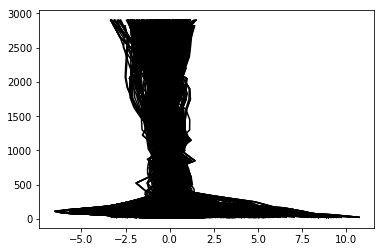

In [3]:
root='/Users/omer/Documents/CitcomS_Assim_Models/DeBeers_Packages/gld422/gld422_GPlates/NNR_InFiles/'
here= '/Users/omer/Documents/Programming/PyGplates/'
rotation_file1 = root + '1000-410_rotations-NNR.rot'
rotation_file2 = root + 'Global_EB_410-250Ma_GK07_2017-NNR.rot'
rotation_file3 = root + 'Global_EB_250-0Ma_GK07_2017-NNR.rot'
rotation_file4 = root + 'NR_0Ma_1000Ma_for_gplates.rot'

rotation_model = pygplates.RotationModel([rotation_file1,rotation_file2,rotation_file3,rotation_file4])



kimberlite_file='/Volumes/Accelsior4M2/ada2/KimberlitesReconstructed/Tappe-et-al-2018-EPSL-Kimberlite_emplacement_ages-automatic-part1-with-locations-with-plate-IDs.gpml'
point_features = pygplates.FeatureCollection(kimberlite_file)

# kimberlite_dir = "/Users/omer/Documents/Data_Tomography_Geology"
# kimberlite_file = "%s/T18_centroids_2017NNR_plateIDs.gpml" %(kimberlite_dir)


grid_dir='/Users/omer/Documents/Data_Tomography_Geology/Tomography_models/savani/Tomography'
f=open('/Users/omer/Documents/Data_Tomography_Geology/savani_depths.txt','r')

DEPTHLIST=[]
for line in f:
    DEPTHLIST.append(line.strip())

step=-20

window=10
agemin=-1

agemina=agemin

agemax=200

agemaxa=agemax

anchor_plate_id=0

AllLats=[]
AllLons=[]

for age1 in xrange(agemax,agemin,step):
    
    age2 = age1+window # 1st iteration:210 Ma 
    age1f=float(age1)-window # 190
    age2f=float(age2) # 210
    ageofVtk=age1 # 200
    ageofVtkf=float(ageofVtk)
    
    
    # Start with an empty list of features that appear between age1 and age2 Ma.
#     features_to_modify = []
    
#     for feature in point_features:
#         name = feature.get_name()
#         begin_time, end_time = feature.get_valid_time()
     
#         if begin_time < age1f and begin_time >= age2f:
#             feature.set_valid_time(age1f, age2f)
#             features_to_modify.append(feature)
    
    
    Lons=[]
    Lats=[]
    numKimb=0
    for feature in point_features:
        
        point = feature.get_geometry()
        PlateID = feature.get_reconstruction_plate_id()
        BirthTime=feature.get_valid_time()[0]
        
        if BirthTime < age2f and BirthTime >= age1f:
            PlateRotation = rotation_model.get_rotation(ageofVtk, PlateID, anchor_plate_id)
            reconstructed_point = PlateRotation * point
            reconstructed_point_degrees = reconstructed_point.to_lat_lon_point()
            Lats.append(reconstructed_point_degrees.get_latitude())
            Lons.append(reconstructed_point_degrees.get_longitude())
            numKimb=numKimb+1
        
#             feature.set_valid_time(age1f, age2f)
            
#             features_to_modify.append(feature)
            
        
#         a,b= PlateRotation.get_euler_pole_and_angle()
#         print a,b," : are Euler Pole and Angle, resp."
#         reconstructed_point = PlateRotation * point.get_geometry()
#         reconstructed_point = PlateRotation * point
#         print point," is recons. to: ",reconstructed_point, " with PlateID", PlateID

    
    print numKimb, " kimberlites at ", ageofVtkf  

        
    AllLats.extend(Lats)
    AllLons.extend(Lons)
    

vs_at_p_all_depths_all_points=[]
vs_at_p_all_depths=[]
index=0    
for latitude in AllLats:
    vs_at_p_all_depths=[]
    for depth in DEPTHLIST:
#     print depth
        tomo_pile_input_file = "%s/savani_%d.nc" %(grid_dir, int(depth))  
           
#         print latitude
        vs_at_p_d = sample_using_gmt(tomo_pile_input_file, AllLons[index], latitude)
        
        vs_at_p_all_depths.append(vs_at_p_d)
        
    plt.plot(vs_at_p_all_depths,np.asarray(DEPTHLIST,dtype="float64"),c='k')

    
    vs_at_p_all_depths_all_points.append(vs_at_p_all_depths)
    
    
#     Vs_mean_global=np.append(Vs_mean_global,mean)
    index=index+1


np.savetxt("Savani_std.txt",np.std(vs_at_p_all_depths_all_points,axis=0))



# gypsumS

grid_dir='/Users/omer/Documents/Data_Tomography_Geology/Tomography_models/GypsumS/Tomography/'
f=open('/Users/omer/Documents/Data_Tomography_Geology/GypsumS_depths.txt','r')

DEPTHLIST=[]
for line in f:
    DEPTHLIST.append(line.strip())
    
vs_at_p_all_depths_all_points_gypsum=[]
vs_at_p_all_depths=[]
index=0    
for latitude in AllLats:
    vs_at_p_all_depths_gypsum=[]
    for depth in DEPTHLIST:
#     print depth
        tomo_pile_input_file = "%s/GypsumS_%d.nc" %(grid_dir, int(depth))  
           
        
#         print latitude
        vs_at_p_d = sample_using_gmt(tomo_pile_input_file, AllLons[index], latitude)
        
        vs_at_p_all_depths_gypsum.append(vs_at_p_d)
        
    plt.plot(vs_at_p_all_depths_gypsum,np.asarray(DEPTHLIST,dtype="float64"),c='k')

    
    vs_at_p_all_depths_all_points_gypsum.append(vs_at_p_all_depths_gypsum)

    
#     Vs_mean_global_gypsum=np.append(Vs_mean_global,mean)
    index=index+1


np.savetxt("Gypsums_std.txt",np.std(vs_at_p_all_depths_all_points_gypsum,axis=0))




# S40RTS
       
grid_dir='/Users/omer/Documents/Data_Tomography_Geology/Tomography_models/s40rts/Tomography/'
f=open('/Users/omer/Documents/Data_Tomography_Geology/s40rts_depths.txt','r')

DEPTHLIST=[]
for line in f:
    DEPTHLIST.append(line.strip())
    
    
vs_at_p_all_depths_all_points_s40rts=[]
vs_at_p_all_depths=[]
index=0    
for latitude in AllLats:
    vs_at_p_all_depths_s40rts=[]
    for depth in DEPTHLIST:
#     print depth
        tomo_pile_input_file = "%s/s40rts_%d.nc" %(grid_dir, int(depth))  
           
        
#         print latitude
        vs_at_p_d = sample_using_gmt(tomo_pile_input_file, AllLons[index], latitude)
        
        vs_at_p_all_depths_s40rts.append(vs_at_p_d)
        
    plt.plot(vs_at_p_all_depths_s40rts,np.asarray(DEPTHLIST,dtype="float64"),c='k')

    
    vs_at_p_all_depths_all_points_s40rts.append(vs_at_p_all_depths_s40rts)

    
#     Vs_mean_global_gypsum=np.append(Vs_mean_global,mean)
    index=index+1

np.savetxt("s40rts_std.txt",np.std(vs_at_p_all_depths_all_points_s40rts,axis=0))

       
     
# SEMUCB-WM1


grid_dir='/Users/omer/Documents/Data_Tomography_Geology/Tomography_models/SEMUCB-WM1/Tomography/'
f=open('/Users/omer/Documents/Data_Tomography_Geology/semucb-wm1_depths.txt','r')

DEPTHLIST=[]
for line in f:
    DEPTHLIST.append(line.strip())
    
vs_at_p_all_depths_all_points_semucb_wm1=[]
vs_at_p_all_depths=[]       
       
index=0    
for latitude in AllLats:
    vs_at_p_all_depths_semucb_wm1=[]
    sayindex=1
    for depth in DEPTHLIST:
#     print depth
        tomo_pile_input_file = "%s/SEMUCB-WM1_%d.nc" %(grid_dir, int(depth))  
           
        
#         print latitude
        vs_at_p_d = sample_using_gmt(tomo_pile_input_file, AllLons[index], latitude)
        
        vs_at_p_all_depths_semucb_wm1.append(vs_at_p_d)
        sayindex=sayindex+1
        
#     plt.plot(vs_at_p_all_depths_semucb_wm1,np.asarray(DEPTHLIST,dtype="float64"),c='k')

    
    vs_at_p_all_depths_all_points_semucb_wm1.append(vs_at_p_all_depths_semucb_wm1)

    
#     Vs_mean_global_gypsum=np.append(Vs_mean_global,mean)
    index=index+1       

np.savetxt("semucb_std.txt",np.std(vs_at_p_all_depths_all_points_semucb_wm1,axis=0))

       
# plt.gca().invert_yaxis()
# plt.xlabel("%dVs")
# plt.ylabel("Depth (km)")
# plt.gca().figure.dpi=300    
# plt.show()
    
        
# Elle=vs_at_p_all_depths_all_points.reshape(3,763)        
    
#     for p in features_to_modify:
    
#     #the code below uses pygplates to find point latitudes and longitudes
#     point = p.get_geometry()
#     ID=p.get_reconstruction_plate_id()
#     point_degrees = point.to_lat_lon_point()
#     point_lon = point_degrees.get_longitude()
#     point_lat = point_degrees.get_latitude()
#     eruptionTime= ageofVtkf
    
#     # reconstruct the point
#     #the code below finds the value of the tomography model at a given point and depth    
#     vs_at_p_all_depths =[]
#     for depth in DEPTHLIST:
#         tomo_pile_input_file = "%s/savani_%d.nc" %(grid_dir, int(depth))  
#         vs_at_p_d = sample_using_gmt(tomo_pile_input_file, point_lon, point_lat)
#         vs_at_p_all_depths.append(vs_at_p_d)
        
#     vs_at_p_all_depths_all_points.append(vs_at_p_all_depths)
    
    
    ##the list vs_at_p_all_depths_all_points should contain all 1-D profiles of Vs over depth
#     vs_at_p = sample_using_gmt(tomo_pile_input_file, point_lon, point_lat)
    
#     print(vs_at_p)

# GET STD of TOMOGRAPHIC MODELS M21

18  kimberlites at  200.0
40  kimberlites at  180.0
66  kimberlites at  160.0
93  kimberlites at  140.0
64  kimberlites at  120.0
120  kimberlites at  100.0
166  kimberlites at  80.0
83  kimberlites at  60.0
11  kimberlites at  40.0
3  kimberlites at  20.0
1  kimberlites at  0.0


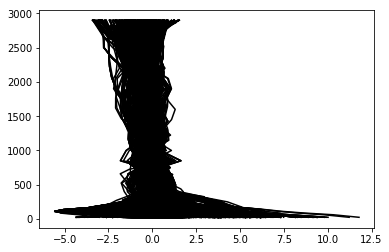

In [20]:
# root='/Users/omer/Documents/CitcomS_Assim_Models/DeBeers_Packages/gld422/gld422_GPlates/NNR_InFiles/'
# here= '/Users/omer/Documents/Programming/PyGplates/'
# rotation_file1 = root + '1000-410_rotations-NNR.rot'
# rotation_file2 = root + 'Global_EB_410-250Ma_GK07_2017-NNR.rot'
# rotation_file3 = root + 'Global_EB_250-0Ma_GK07_2017-NNR.rot'
# rotation_file4 = root + 'NR_0Ma_1000Ma_for_gplates.rot'



# root='/Users/omer/Downloads/Supplement/Reconstructions/M21/'
# here= '/Users/omer/Documents/Programming/PyGplates/'
# rotation_file = root + '1000_0_rotfile_Merdith_et_al.rot'

ReconstructionDir='/Users/omer/Desktop/NatGeoReviews/Reconstruction_Models/M21/'

cratonFile=ReconstructionDir+"shapes_cratons_Merdith_et_al.gpml"
cratons = pygplates.FeatureCollection(cratonFile)    

input_rotation_filename = '%s/1000_0_rotfile_Merdith_et_al.rot' % ReconstructionDir

rotation_model = pygplates.RotationModel(input_rotation_filename)



kimberlite_file='/Volumes/Accelsior4M2/ada2/KimberlitesReconstructed/Tappe-et-al-2018-EPSL-Kimberlite_emplacement_ages-automatic-part1-with-locations-with-plate-IDs.gpml'
point_features = pygplates.FeatureCollection(kimberlite_file)

# kimberlite_dir = "/Users/omer/Documents/Data_Tomography_Geology"
# kimberlite_file = "%s/T18_centroids_2017NNR_plateIDs.gpml" %(kimberlite_dir)


grid_dir='/Users/omer/Documents/Data_Tomography_Geology/Tomography_models/savani/Tomography'
f=open('/Users/omer/Documents/Data_Tomography_Geology/savani_depths.txt','r')

DEPTHLIST=[]
for line in f:
    DEPTHLIST.append(line.strip())

step=-20

window=10
agemin=-1

agemina=agemin

agemax=200

agemaxa=agemax

anchor_plate_id=0

AllLats=[]
AllLons=[]

for age1 in xrange(agemax,agemin,step):
    
    age2 = age1+window # 1st iteration:210 Ma 
    age1f=float(age1)-window # 190
    age2f=float(age2) # 210
    ageofVtk=age1 # 200
    ageofVtkf=float(ageofVtk)
    
    
    # Start with an empty list of features that appear between age1 and age2 Ma.
#     features_to_modify = []
    
#     for feature in point_features:
#         name = feature.get_name()
#         begin_time, end_time = feature.get_valid_time()
     
#         if begin_time < age1f and begin_time >= age2f:
#             feature.set_valid_time(age1f, age2f)
#             features_to_modify.append(feature)
    
    
    Lons=[]
    Lats=[]
    numKimb=0
    for feature in point_features:
        
        point = feature.get_geometry()
        PlateID = feature.get_reconstruction_plate_id()
        BirthTime=feature.get_valid_time()[0]
        
        if BirthTime < age2f and BirthTime >= age1f:
            PlateRotation = rotation_model.get_rotation(ageofVtk, PlateID, anchor_plate_id)
            reconstructed_point = PlateRotation * point
            reconstructed_point_degrees = reconstructed_point.to_lat_lon_point()
            Lats.append(reconstructed_point_degrees.get_latitude())
            Lons.append(reconstructed_point_degrees.get_longitude())
            numKimb=numKimb+1
        
#             feature.set_valid_time(age1f, age2f)
            
#             features_to_modify.append(feature)
            
        
#         a,b= PlateRotation.get_euler_pole_and_angle()
#         print a,b," : are Euler Pole and Angle, resp."
#         reconstructed_point = PlateRotation * point.get_geometry()
#         reconstructed_point = PlateRotation * point
#         print point," is recons. to: ",reconstructed_point, " with PlateID", PlateID

    
    print numKimb, " kimberlites at ", ageofVtkf  

        
    AllLats.extend(Lats)
    AllLons.extend(Lons)
    

vs_at_p_all_depths_all_points=[]
vs_at_p_all_depths=[]
index=0    
for latitude in AllLats:
    vs_at_p_all_depths=[]
    for depth in DEPTHLIST:
#     print depth
        tomo_pile_input_file = "%s/savani_%d.nc" %(grid_dir, int(depth))  
           
#         print latitude
        vs_at_p_d = sample_using_gmt(tomo_pile_input_file, AllLons[index], latitude)
        
        vs_at_p_all_depths.append(vs_at_p_d)
        
    plt.plot(vs_at_p_all_depths,np.asarray(DEPTHLIST,dtype="float64"),c='k')

    
    vs_at_p_all_depths_all_points.append(vs_at_p_all_depths)
    
    
#     Vs_mean_global=np.append(Vs_mean_global,mean)
    index=index+1


np.savetxt("Savani_std_M21.txt",np.std(vs_at_p_all_depths_all_points,axis=0))



# gypsumS

grid_dir='/Users/omer/Documents/Data_Tomography_Geology/Tomography_models/GypsumS/Tomography/'
f=open('/Users/omer/Documents/Data_Tomography_Geology/GypsumS_depths.txt','r')

DEPTHLIST=[]
for line in f:
    DEPTHLIST.append(line.strip())
    
vs_at_p_all_depths_all_points_gypsum=[]
vs_at_p_all_depths=[]
index=0    
for latitude in AllLats:
    vs_at_p_all_depths_gypsum=[]
    for depth in DEPTHLIST:
#     print depth
        tomo_pile_input_file = "%s/GypsumS_%d.nc" %(grid_dir, int(depth))  
           
        
#         print latitude
        vs_at_p_d = sample_using_gmt(tomo_pile_input_file, AllLons[index], latitude)
        
        vs_at_p_all_depths_gypsum.append(vs_at_p_d)
        
    plt.plot(vs_at_p_all_depths_gypsum,np.asarray(DEPTHLIST,dtype="float64"),c='k')

    
    vs_at_p_all_depths_all_points_gypsum.append(vs_at_p_all_depths_gypsum)

    
#     Vs_mean_global_gypsum=np.append(Vs_mean_global,mean)
    index=index+1


np.savetxt("Gypsums_std_M21.txt",np.std(vs_at_p_all_depths_all_points_gypsum,axis=0))




# S40RTS
       
grid_dir='/Users/omer/Documents/Data_Tomography_Geology/Tomography_models/s40rts/Tomography/'
f=open('/Users/omer/Documents/Data_Tomography_Geology/s40rts_depths.txt','r')

DEPTHLIST=[]
for line in f:
    DEPTHLIST.append(line.strip())
    
    
vs_at_p_all_depths_all_points_s40rts=[]
vs_at_p_all_depths=[]
index=0    
for latitude in AllLats:
    vs_at_p_all_depths_s40rts=[]
    for depth in DEPTHLIST:
#     print depth
        tomo_pile_input_file = "%s/s40rts_%d.nc" %(grid_dir, int(depth))  
           
        
#         print latitude
        vs_at_p_d = sample_using_gmt(tomo_pile_input_file, AllLons[index], latitude)
        
        vs_at_p_all_depths_s40rts.append(vs_at_p_d)
        
    plt.plot(vs_at_p_all_depths_s40rts,np.asarray(DEPTHLIST,dtype="float64"),c='k')

    
    vs_at_p_all_depths_all_points_s40rts.append(vs_at_p_all_depths_s40rts)

    
#     Vs_mean_global_gypsum=np.append(Vs_mean_global,mean)
    index=index+1

np.savetxt("s40rts_std_M21.txt",np.std(vs_at_p_all_depths_all_points_s40rts,axis=0))

       
     
# SEMUCB-WM1


grid_dir='/Users/omer/Documents/Data_Tomography_Geology/Tomography_models/SEMUCB-WM1/Tomography/'
f=open('/Users/omer/Documents/Data_Tomography_Geology/semucb-wm1_depths.txt','r')

DEPTHLIST=[]
for line in f:
    DEPTHLIST.append(line.strip())
    
vs_at_p_all_depths_all_points_semucb_wm1=[]
vs_at_p_all_depths=[]       
       
index=0    
for latitude in AllLats:
    vs_at_p_all_depths_semucb_wm1=[]
    sayindex=1
    for depth in DEPTHLIST:
#     print depth
        tomo_pile_input_file = "%s/SEMUCB-WM1_%d.nc" %(grid_dir, int(depth))  
           
        
#         print latitude
        vs_at_p_d = sample_using_gmt(tomo_pile_input_file, AllLons[index], latitude)
        
        vs_at_p_all_depths_semucb_wm1.append(vs_at_p_d)
        sayindex=sayindex+1
        
#     plt.plot(vs_at_p_all_depths_semucb_wm1,np.asarray(DEPTHLIST,dtype="float64"),c='k')

    
    vs_at_p_all_depths_all_points_semucb_wm1.append(vs_at_p_all_depths_semucb_wm1)

    
#     Vs_mean_global_gypsum=np.append(Vs_mean_global,mean)
    index=index+1       

np.savetxt("semucb_std_M21.txt",np.std(vs_at_p_all_depths_all_points_semucb_wm1,axis=0))

       
# plt.gca().invert_yaxis()
# plt.xlabel("%dVs")
# plt.ylabel("Depth (km)")
# plt.gca().figure.dpi=300    
# plt.show()
    
        
# Elle=vs_at_p_all_depths_all_points.reshape(3,763)        
    
#     for p in features_to_modify:
    
#     #the code below uses pygplates to find point latitudes and longitudes
#     point = p.get_geometry()
#     ID=p.get_reconstruction_plate_id()
#     point_degrees = point.to_lat_lon_point()
#     point_lon = point_degrees.get_longitude()
#     point_lat = point_degrees.get_latitude()
#     eruptionTime= ageofVtkf
    
#     # reconstruct the point
#     #the code below finds the value of the tomography model at a given point and depth    
#     vs_at_p_all_depths =[]
#     for depth in DEPTHLIST:
#         tomo_pile_input_file = "%s/savani_%d.nc" %(grid_dir, int(depth))  
#         vs_at_p_d = sample_using_gmt(tomo_pile_input_file, point_lon, point_lat)
#         vs_at_p_all_depths.append(vs_at_p_d)
        
#     vs_at_p_all_depths_all_points.append(vs_at_p_all_depths)
    
    
    ##the list vs_at_p_all_depths_all_points should contain all 1-D profiles of Vs over depth
#     vs_at_p = sample_using_gmt(tomo_pile_input_file, point_lon, point_lat)
    
#     print(vs_at_p)

In [52]:
d=np.asarray(vs_at_p_all_depths_all_points)
# np.std(vs_at_p_all_depths_all_points,axis=0).shape

In [57]:
np.std(vs_at_p_all_depths_all_points,axis=0)

array([[2.07251407],
       [1.82125589],
       [2.02597027],
       [2.15938046],
       [1.95764129],
       [1.50883416],
       [1.01317723],
       [0.66303525],
       [0.48163749],
       [0.41493964],
       [0.43012731],
       [0.45468941],
       [0.43501032],
       [0.36725139],
       [0.33042576],
       [0.36055051],
       [0.37730421],
       [0.38058918],
       [0.38058918],
       [0.37840397],
       [0.38663244],
       [0.3765032 ],
       [0.39175413],
       [0.40137282],
       [0.41553841],
       [0.47670477],
       [0.54929293],
       [0.62798641],
       [0.70540225]])

In [29]:
vs_at_p_all_depths

[array([1.0020982]),
 array([-1.18349886]),
 array([-3.3273623]),
 array([-4.46722603]),
 array([-4.33193064]),
 array([-3.37234211]),
 array([-2.21671748]),
 array([-1.26892209]),
 array([-0.51459962]),
 array([0.21981266]),
 array([0.65245146]),
 array([0.7172116]),
 array([0.4829517]),
 array([0.29488575]),
 array([0.03215938]),
 array([-0.4152607]),
 array([-0.73626411]),
 array([-0.92982507]),
 array([-0.92982507]),
 array([-0.99095809]),
 array([-1.02351844]),
 array([-0.89846122]),
 array([-0.7494846]),
 array([-0.51712114]),
 array([-0.26017234]),
 array([-0.11691362]),
 array([0.10822734]),
 array([0.20100324]),
 array([0.22018024])]

In [9]:
#dd=np.asarray(vs_at_p_all_depths_all_points,dtype="float64") 
# vs_at_p_all_depths_all_points

np.asarray(dd,dtype="float64")

array([[[ 4.10520411],
        [ 2.60074592],
        [ 1.36729276],
        ...,
        [-0.11790641],
        [-0.17684379],
        [-0.20489152]],

       [[ 7.56113625],
        [ 4.57501698],
        [ 2.02798009],
        ...,
        [-0.47384614],
        [-0.38403642],
        [-0.32704577]],

       [[ 3.09795022],
        [ 2.58726168],
        [ 1.40216339],
        ...,
        [ 0.1358069 ],
        [ 0.11221043],
        [ 0.12887266]],

       ...,

       [[ 0.44246203],
        [-1.42052197],
        [-2.88657808],
        ...,
        [ 0.79074359],
        [ 0.75089687],
        [ 0.79102767]],

       [[ 0.86090279],
        [-0.14295043],
        [-1.37518001],
        ...,
        [ 0.81892884],
        [ 1.07044435],
        [ 1.35401595]],

       [[ 3.76387358],
        [ 1.0674789 ],
        [-1.31170666],
        ...,
        [-0.19160274],
        [-0.31468126],
        [-0.37194324]]])

In [10]:
vs_at_p_all_depths_all_points

[[array([4.10520411]),
  array([2.60074592]),
  array([1.36729276]),
  array([0.75320971]),
  array([0.75014114]),
  array([0.90328008]),
  array([0.93339527]),
  array([0.89515358]),
  array([0.96584076]),
  array([1.12523544]),
  array([1.1535238]),
  array([0.95987713]),
  array([0.51484978]),
  array([0.1356017]),
  array([-0.16174443]),
  array([-0.36152816]),
  array([-0.47489458]),
  array([-0.4735707]),
  array([-0.4735707]),
  array([-0.37948698]),
  array([-0.1334185]),
  array([0.14331543]),
  array([0.20417444]),
  array([0.08948971]),
  array([-0.0047815]),
  array([-0.03688106]),
  array([-0.11790641]),
  array([-0.17684379]),
  array([-0.20489152])],
 [array([7.56113625]),
  array([4.57501698]),
  array([2.02798009]),
  array([0.39435577]),
  array([-0.29104504]),
  array([-0.47805437]),
  array([-0.56283873]),
  array([-0.64304316]),
  array([-0.45689842]),
  array([-0.01958628]),
  array([0.28149599]),
  array([0.33577192]),
  array([0.26427475]),
  array([0.13276067])

In [ ]:
np.asarray(vs_at_p_all_depths_all_points).shape


In [ ]:
!pwd

In [32]:
np.save("/Users/omer/Documents/Data_Tomography_Geology/Tomography_models/savani/KimberliteField_below_Savani_Reconstructed_200Ma_0Ma.npy",
        np.asarray(vs_at_p_all_depths_all_points,dtype="float64"))

In [4]:
Kimb_below_Savani=np.load("/Users/omer/Documents/Data_Tomography_Geology/Tomography_models/savani/KimberliteField_below_Savani_Reconstructed_200Ma_0Ma.npy")


In [7]:
# Kimb_below_Savani
Kimb_below_Savani

array([[[ 2.21608496],
        [-0.10992112],
        [-2.3296392 ],
        ...,
        [-0.11816796],
        [-0.05126892],
        [ 0.02578843]],

       [[ 2.21608496],
        [-0.10992112],
        [-2.3296392 ],
        ...,
        [-0.11816796],
        [-0.05126892],
        [ 0.02578843]],

       [[ 1.76643682],
        [-0.41847381],
        [-2.57296896],
        ...,
        [-0.10195895],
        [-0.03448882],
        [ 0.00543907]],

       ...,

       [[ 3.08294177],
        [ 3.96917152],
        [ 4.49069691],
        ...,
        [-1.33833957],
        [-1.37971807],
        [-1.36155462]],

       [[ 4.72241163],
        [ 5.01381397],
        [ 4.8217206 ],
        ...,
        [-1.9074502 ],
        [-1.83124423],
        [-1.78816366]],

       [[ 2.06682634],
        [ 3.19432545],
        [ 3.41464043],
        ...,
        [-0.98139739],
        [-0.99673772],
        [-0.93164474]]])

In [ ]:
MyDataFrameSavani=pd.DataFrame(Kimb_below_Savani.reshape(762,29))

In [4]:
SavaniMean=[]
Savani_STD=[]
for depth in DEPTHLIST:
#     print depth
    tomo_pile_input_file = "%s/savani_%d.nc" %(grid_dir, int(depth))  
           
        

    mean=float(call_system_command(['gmt',

                         'grdinfo',

                         '-Cn',

                         '-L2',

                         '-o10',

                         '%s' % tomo_pile_input_file],

                          return_stdout=True))

    SavaniMean.append(mean)
    
    std=float(call_system_command(['gmt',

                     'grdinfo',

                     '-Cn',

                     '-L2',

                     '-o11',

                     '%s' % tomo_pile_input_file],

                      return_stdout=True))

    Savani_STD.append(std)
    

NameError: name 'DEPTHLIST' is not defined

In [ ]:
SavaniMean

# GypsumS Analysis

2  kimberlites at  198.0
2  kimberlites at  196.0
2  kimberlites at  194.0
0  kimberlites at  192.0
2  kimberlites at  190.0
1  kimberlites at  188.0
1  kimberlites at  186.0
2  kimberlites at  184.0
4  kimberlites at  182.0
4  kimberlites at  180.0
2  kimberlites at  178.0
6  kimberlites at  176.0
4  kimberlites at  174.0
5  kimberlites at  172.0
8  kimberlites at  170.0
3  kimberlites at  168.0
0  kimberlites at  166.0
4  kimberlites at  164.0
2  kimberlites at  162.0
5  kimberlites at  160.0
6  kimberlites at  158.0
8  kimberlites at  156.0
8  kimberlites at  154.0
7  kimberlites at  152.0
9  kimberlites at  150.0
7  kimberlites at  148.0
15  kimberlites at  146.0
11  kimberlites at  144.0
6  kimberlites at  142.0
9  kimberlites at  140.0
13  kimberlites at  138.0
5  kimberlites at  136.0
14  kimberlites at  134.0
16  kimberlites at  132.0
7  kimberlites at  130.0
11  kimberlites at  128.0
10  kimberlites at  126.0
13  kimberlites at  124.0
7  kimberlites at  122.0
12  kimberlites a

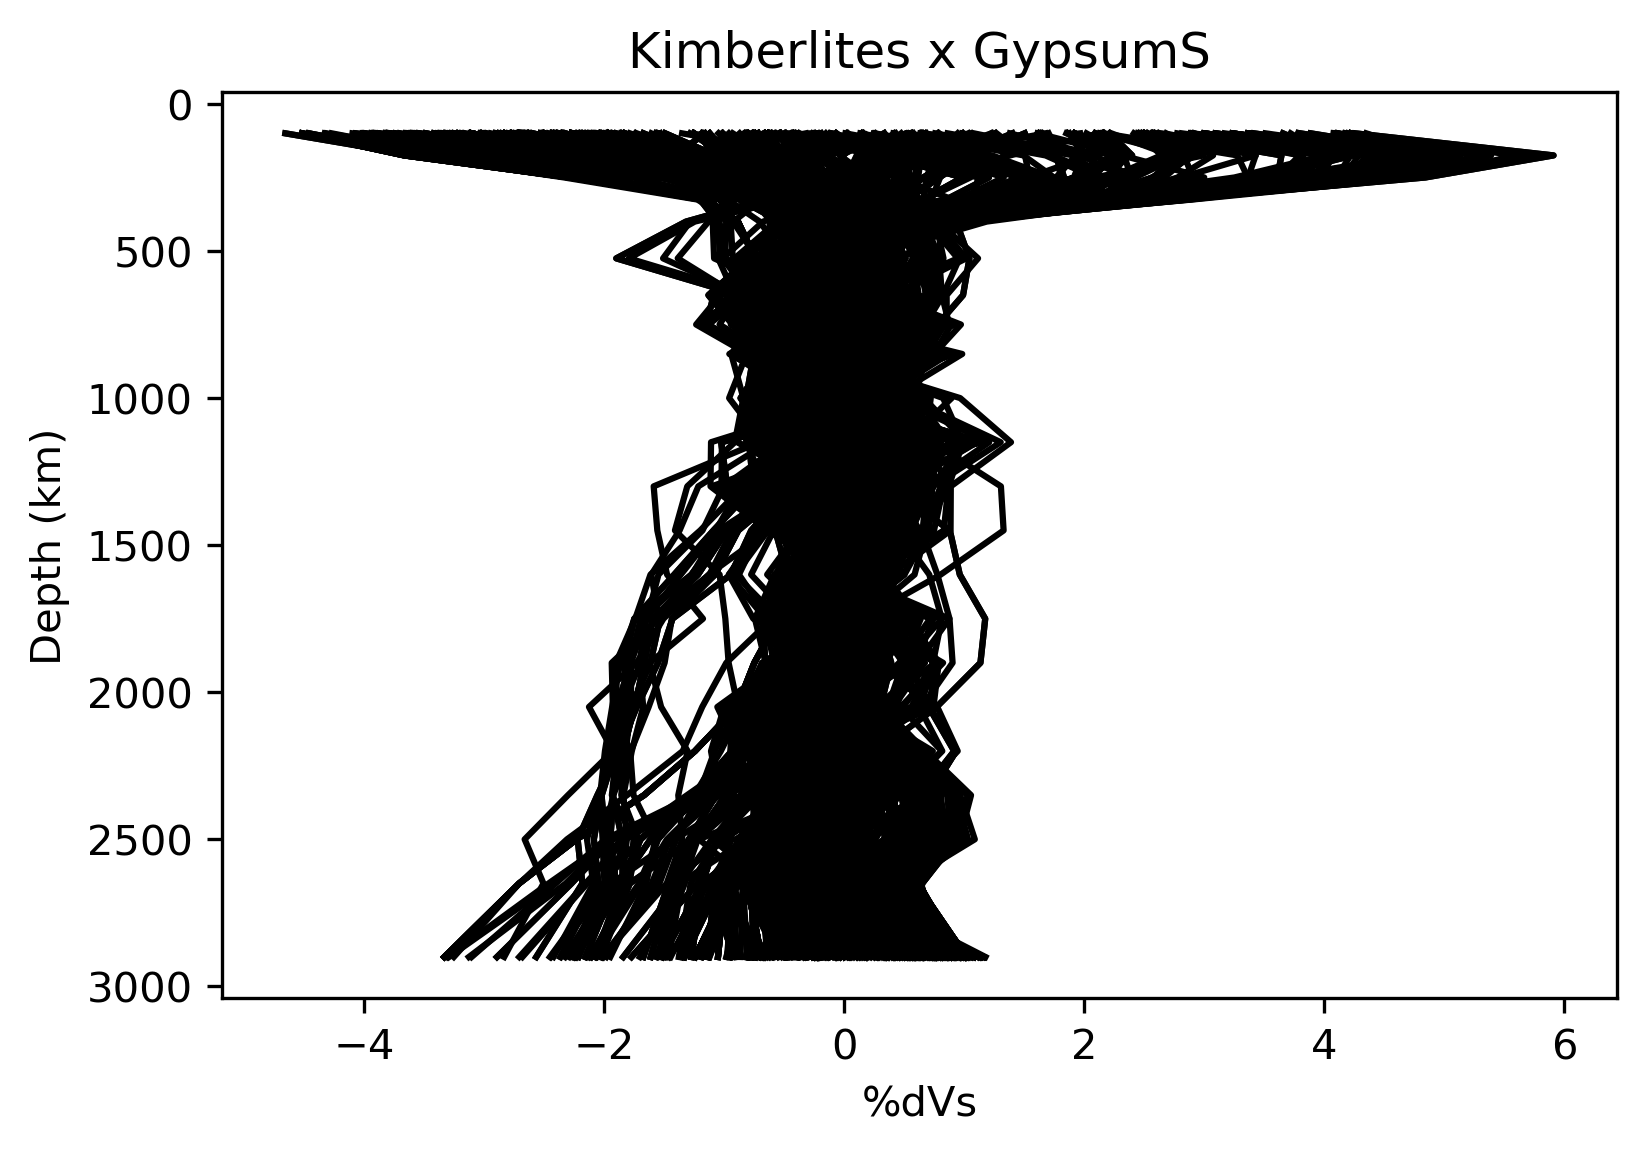

In [19]:
root='/Users/omer/Documents/CitcomS_Assim_Models/DeBeers_Packages/gld422/gld422_GPlates/NNR_InFiles/'

here= '/Users/omer/Documents/Programming/PyGplates/'
rotation_file1 = root + '1000-410_rotations-NNR.rot'
rotation_file2 = root + 'Global_EB_410-250Ma_GK07_2017-NNR.rot'
rotation_file3 = root + 'Global_EB_250-0Ma_GK07_2017-NNR.rot'
rotation_file4 = root + 'NR_0Ma_1000Ma_for_gplates.rot'

rotation_model = pygplates.RotationModel([rotation_file1,rotation_file2,rotation_file3,rotation_file4])

grid_dir='/Users/omer/Documents/Data_Tomography_Geology/Tomography_models/GypsumS/Tomography'



f=open('/Users/omer/Documents/Data_Tomography_Geology/GypsumS_depths.txt','r')

DEPTHLIST=[]
for line in f:
    DEPTHLIST.append(line.strip())

step=-2

agemin=-2

agemina=agemin

agemax=200

agemaxa=agemax

anchor_plate_id=0

AllLats=[]
AllLons=[]
vs_at_p_all_depths_all_points_gypsum=[]
filenames = []
vs_at_p_all_depths_gypsum=[]

for age1 in xrange(agemax,agemin,step):
    
    age2 = age1+step # 1st iteration:330 Ma - 310 Ma
    age1f=float(age1)
    age2f=float(age2)
    ageofVtk=age1+step
    ageofVtkf=float(ageofVtk)
    
    
    # Start with an empty list of features that appear between age1 and age2 Ma.
#     features_to_modify = []
    
#     for feature in point_features:
#         name = feature.get_name()
#         begin_time, end_time = feature.get_valid_time()
     
#         if begin_time < age1f and begin_time >= age2f:
#             feature.set_valid_time(age1f, age2f)
#             features_to_modify.append(feature)
    
    
    Lons=[]
    Lats=[]
    numKimb=0
    for feature in point_features:
        
        point = feature.get_geometry()
        PlateID = feature.get_reconstruction_plate_id()
        BirthTime=feature.get_valid_time()[0]
        
        if BirthTime < age1f and BirthTime >= age2f:
            PlateRotation = rotation_model.get_rotation(ageofVtk, PlateID, anchor_plate_id)
            reconstructed_point = PlateRotation * point
            reconstructed_point_degrees = reconstructed_point.to_lat_lon_point()
            Lats.append(reconstructed_point_degrees.get_latitude())
            Lons.append(reconstructed_point_degrees.get_longitude())
            numKimb=numKimb+1
        
#             feature.set_valid_time(age1f, age2f)
            
#             features_to_modify.append(feature)
            
        
#         a,b= PlateRotation.get_euler_pole_and_angle()
#         print a,b," : are Euler Pole and Angle, resp."
#         reconstructed_point = PlateRotation * point.get_geometry()
#         reconstructed_point = PlateRotation * point
#         print point," is recons. to: ",reconstructed_point, " with PlateID", PlateID

    
    print numKimb, " kimberlites at ", ageofVtkf  

        
    AllLats.extend(Lats)
    AllLons.extend(Lons)
    


index=0    
for latitude in AllLats:
    vs_at_p_all_depths_gypsum=[]
    for depth in DEPTHLIST:
#     print depth
        tomo_pile_input_file = "%s/GypsumS_%d.nc" %(grid_dir, int(depth))  
           
        
#         print latitude
        vs_at_p_d = sample_using_gmt(tomo_pile_input_file, AllLons[index], latitude)
        
        vs_at_p_all_depths_gypsum.append(vs_at_p_d)
        
    plt.plot(vs_at_p_all_depths_gypsum,np.asarray(DEPTHLIST,dtype="float64"),c='k')

    
    vs_at_p_all_depths_all_points_gypsum.append(vs_at_p_all_depths_gypsum)

    
#     Vs_mean_global_gypsum=np.append(Vs_mean_global,mean)
    index=index+1

    

    
#     vs_at_p_all_depths_all_points=[]
#     vs_at_p_all_depths=[]
    
plt.title('Kimberlites x GypsumS')    
plt.gca().invert_yaxis()
plt.xlabel("%dVs")
plt.ylabel("Depth (km)")
plt.gca().figure.dpi=300    
plt.show()
    
        
# Elle=vs_at_p_all_depths_all_points.reshape(3,763)        
    
#     for p in features_to_modify:
    
#     #the code below uses pygplates to find point latitudes and longitudes
#     point = p.get_geometry()
#     ID=p.get_reconstruction_plate_id()
#     point_degrees = point.to_lat_lon_point()
#     point_lon = point_degrees.get_longitude()
#     point_lat = point_degrees.get_latitude()
#     eruptionTime= ageofVtkf
    
#     # reconstruct the point
#     #the code below finds the value of the tomography model at a given point and depth    
#     vs_at_p_all_depths =[]
#     for depth in DEPTHLIST:
#         tomo_pile_input_file = "%s/savani_%d.nc" %(grid_dir, int(depth))  
#         vs_at_p_d = sample_using_gmt(tomo_pile_input_file, point_lon, point_lat)
#         vs_at_p_all_depths.append(vs_at_p_d)
        
#     vs_at_p_all_depths_all_points.append(vs_at_p_all_depths)
    
    
    ##the list vs_at_p_all_depths_all_points should contain all 1-D profiles of Vs over depth
#     vs_at_p = sample_using_gmt(tomo_pile_input_file, point_lon, point_lat)
    
#     print(vs_at_p)

In [ ]:
# len(DEPTHLIST),np.asarray(vs_at_p_all_depths_all_points).shape

In [20]:
np.save("/Users/omer/Documents/Data_Tomography_Geology/Tomography_models/GypsumS/KimberliteField_below_GypsumS_Reconstructed_200Ma_0Ma.npy",
        np.asarray(vs_at_p_all_depths_all_points_gypsum,dtype="float64"))

In [ ]:
Kimberlites_Below_GypsumS=np.load("/Users/omer/Documents/Data_Tomography_Geology/Tomography_models/GypsumS/KimberliteField_below_GypsumS_Reconstructed_320Ma_0Ma.npy")

In [ ]:
Kimberlites_Below_GypsumS.shape

In [ ]:
MyDataFrameGypsumS=pd.DataFrame(Kimberlites_Below_GypsumS.reshape(762,22))



In [ ]:
# MyDataFrameGypsum=pd.DataFrame(vs_at_p_all_depths_all_points_gypsum)
GypsumS_Mean=[]
GypsumS_STD=[]
for depth in DEPTHLIST:
#     print depth
    tomo_pile_input_file = "%s/GypsumS_%d.nc" %(grid_dir, int(depth))  
           
        

    mean=float(call_system_command(['gmt',

                         'grdinfo',

                         '-Cn',

                         '-L2',

                         '-o10',

                         '%s' % tomo_pile_input_file],

                          return_stdout=True))

    GypsumS_Mean.append(mean)
    
    std=float(call_system_command(['gmt',

                     'grdinfo',

                     '-Cn',

                     '-L2',

                     '-o11',

                     '%s' % tomo_pile_input_file],

                      return_stdout=True))

    GypsumS_STD.append(std)
    

# s40rts analysis

2  kimberlites at  198.0
2  kimberlites at  196.0
2  kimberlites at  194.0
0  kimberlites at  192.0
2  kimberlites at  190.0
1  kimberlites at  188.0
1  kimberlites at  186.0
2  kimberlites at  184.0
4  kimberlites at  182.0
4  kimberlites at  180.0
2  kimberlites at  178.0
6  kimberlites at  176.0
4  kimberlites at  174.0
5  kimberlites at  172.0
8  kimberlites at  170.0
3  kimberlites at  168.0
0  kimberlites at  166.0
4  kimberlites at  164.0
2  kimberlites at  162.0
5  kimberlites at  160.0
6  kimberlites at  158.0
8  kimberlites at  156.0
8  kimberlites at  154.0
7  kimberlites at  152.0
9  kimberlites at  150.0
7  kimberlites at  148.0
15  kimberlites at  146.0
11  kimberlites at  144.0
6  kimberlites at  142.0
9  kimberlites at  140.0
13  kimberlites at  138.0
5  kimberlites at  136.0
14  kimberlites at  134.0
16  kimberlites at  132.0
7  kimberlites at  130.0
11  kimberlites at  128.0
10  kimberlites at  126.0
13  kimberlites at  124.0
7  kimberlites at  122.0
12  kimberlites a

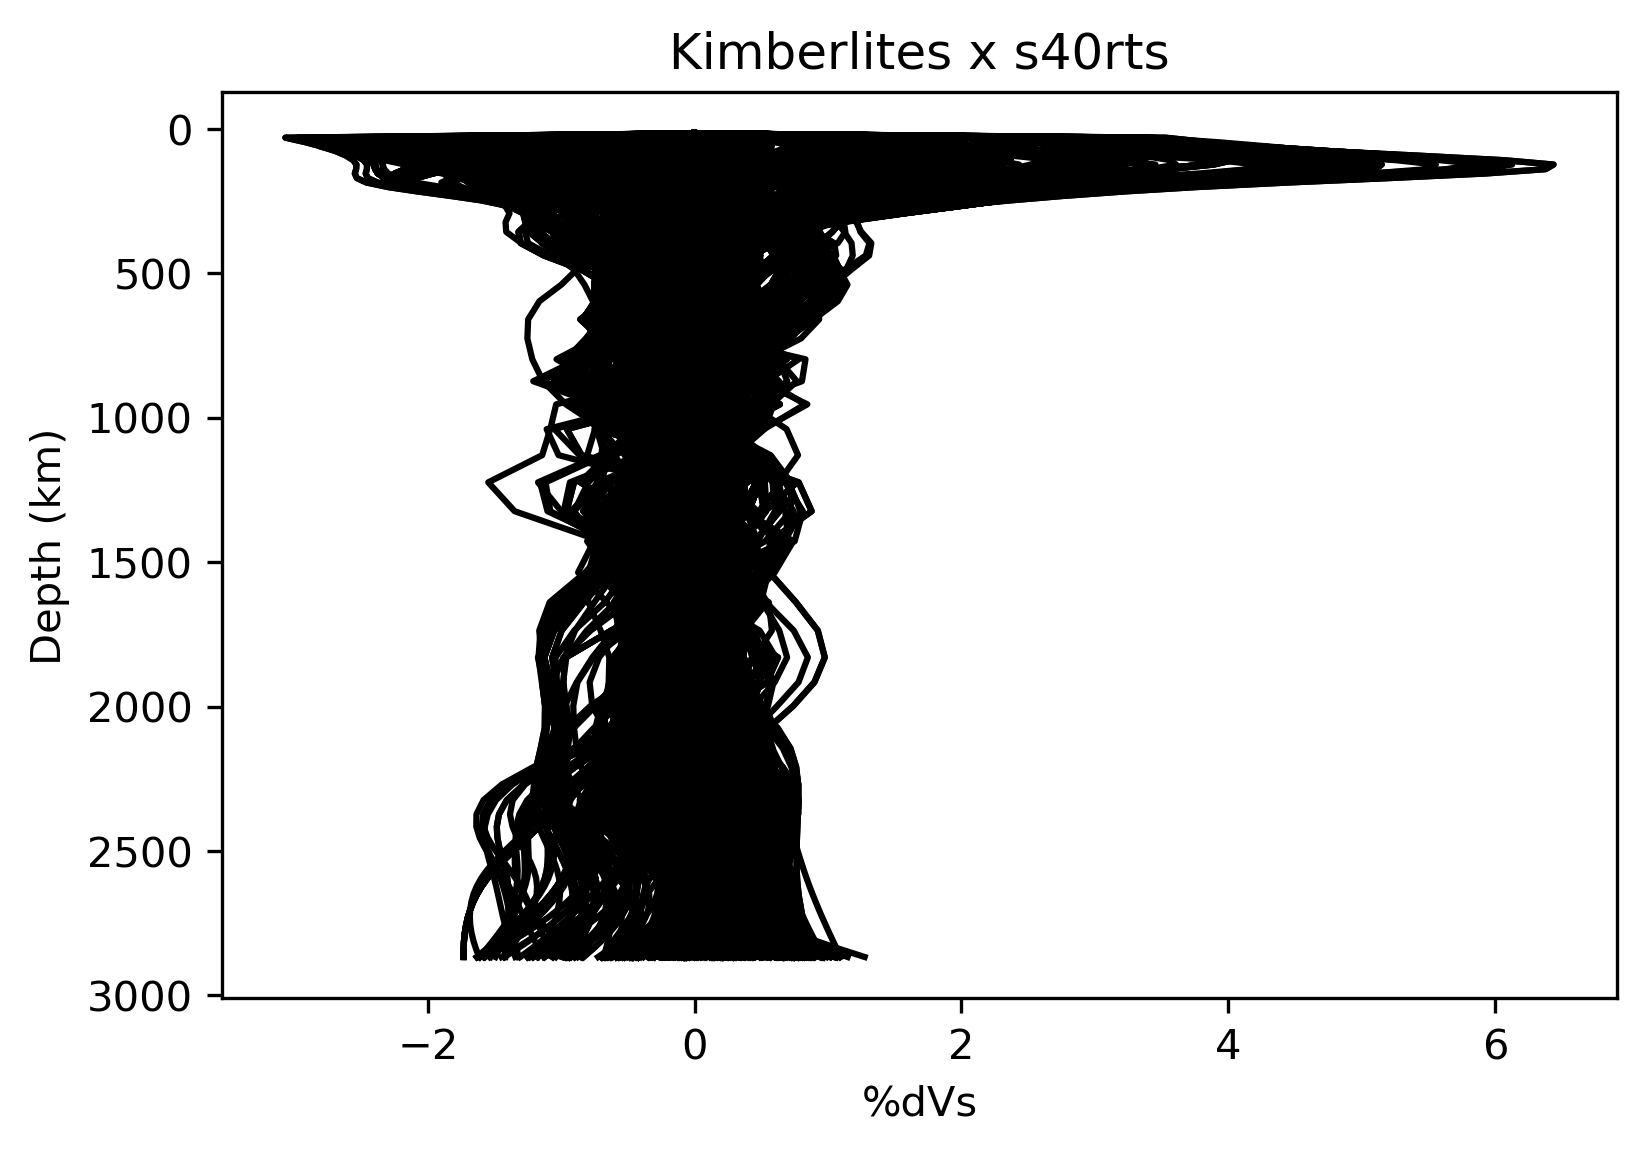

In [18]:
root='/Users/omer/Documents/CitcomS_Assim_Models/DeBeers_Packages/gld422/gld422_GPlates/NNR_InFiles/'

here= '/Users/omer/Documents/Programming/PyGplates/'
rotation_file1 = root + '1000-410_rotations-NNR.rot'
rotation_file2 = root + 'Global_EB_410-250Ma_GK07_2017-NNR.rot'
rotation_file3 = root + 'Global_EB_250-0Ma_GK07_2017-NNR.rot'
rotation_file4 = root + 'NR_0Ma_1000Ma_for_gplates.rot'

rotation_model = pygplates.RotationModel([rotation_file1,rotation_file2,rotation_file3,rotation_file4])

grid_dir='/Users/omer/Documents/Data_Tomography_Geology/Tomography_models/s40rts/Tomography/'



f=open('/Users/omer/Documents/Data_Tomography_Geology/s40rts_depths.txt','r')

DEPTHLIST=[]
for line in f:
    DEPTHLIST.append(line.strip())

step=-2

agemin=-2

agemina=agemin

agemax=200

agemaxa=agemax

anchor_plate_id=0

AllLats=[]
AllLons=[]
vs_at_p_all_depths_all_points_s40rts=[]
filenames = []
vs_at_p_all_depths_s40rts=[]

for age1 in xrange(agemax,agemin,step):
    
    age2 = age1+step # 1st iteration:330 Ma - 310 Ma
    age1f=float(age1)
    age2f=float(age2)
    ageofVtk=age1+step
    ageofVtkf=float(ageofVtk)
    
    
    # Start with an empty list of features that appear between age1 and age2 Ma.
#     features_to_modify = []
    
#     for feature in point_features:
#         name = feature.get_name()
#         begin_time, end_time = feature.get_valid_time()
     
#         if begin_time < age1f and begin_time >= age2f:
#             feature.set_valid_time(age1f, age2f)
#             features_to_modify.append(feature)
    
    
    Lons=[]
    Lats=[]
    numKimb=0
    for feature in point_features:
        
        point = feature.get_geometry()
        PlateID = feature.get_reconstruction_plate_id()
        BirthTime=feature.get_valid_time()[0]
        
        if BirthTime < age1f and BirthTime >= age2f:
            PlateRotation = rotation_model.get_rotation(ageofVtk, PlateID, anchor_plate_id)
            reconstructed_point = PlateRotation * point
            reconstructed_point_degrees = reconstructed_point.to_lat_lon_point()
            Lats.append(reconstructed_point_degrees.get_latitude())
            Lons.append(reconstructed_point_degrees.get_longitude())
            numKimb=numKimb+1
        
#             feature.set_valid_time(age1f, age2f)
            
#             features_to_modify.append(feature)
            
        
#         a,b= PlateRotation.get_euler_pole_and_angle()
#         print a,b," : are Euler Pole and Angle, resp."
#         reconstructed_point = PlateRotation * point.get_geometry()
#         reconstructed_point = PlateRotation * point
#         print point," is recons. to: ",reconstructed_point, " with PlateID", PlateID

    
    print numKimb, " kimberlites at ", ageofVtkf  

        
    AllLats.extend(Lats)
    AllLons.extend(Lons)
    


index=0    
for latitude in AllLats:
    vs_at_p_all_depths_s40rts=[]
    for depth in DEPTHLIST:
#     print depth
        tomo_pile_input_file = "%s/s40rts_%d.nc" %(grid_dir, int(depth))  
           
        
#         print latitude
        vs_at_p_d = sample_using_gmt(tomo_pile_input_file, AllLons[index], latitude)
        
        vs_at_p_all_depths_s40rts.append(vs_at_p_d)
        
    plt.plot(vs_at_p_all_depths_s40rts,np.asarray(DEPTHLIST,dtype="float64"),c='k')

    
    vs_at_p_all_depths_all_points_s40rts.append(vs_at_p_all_depths_s40rts)

    
#     Vs_mean_global_gypsum=np.append(Vs_mean_global,mean)
    index=index+1

    

    
#     vs_at_p_all_depths_all_points=[]
#     vs_at_p_all_depths=[]
    
plt.title('Kimberlites x s40rts')    
plt.gca().invert_yaxis()
plt.xlabel("%dVs")
plt.ylabel("Depth (km)")
plt.gca().figure.dpi=300    
plt.show()
    
        
# Elle=vs_at_p_all_depths_all_points.reshape(3,763)        
    
#     for p in features_to_modify:
    
#     #the code below uses pygplates to find point latitudes and longitudes
#     point = p.get_geometry()
#     ID=p.get_reconstruction_plate_id()
#     point_degrees = point.to_lat_lon_point()
#     point_lon = point_degrees.get_longitude()
#     point_lat = point_degrees.get_latitude()
#     eruptionTime= ageofVtkf
    
#     # reconstruct the point
#     #the code below finds the value of the tomography model at a given point and depth    
#     vs_at_p_all_depths =[]
#     for depth in DEPTHLIST:
#         tomo_pile_input_file = "%s/savani_%d.nc" %(grid_dir, int(depth))  
#         vs_at_p_d = sample_using_gmt(tomo_pile_input_file, point_lon, point_lat)
#         vs_at_p_all_depths.append(vs_at_p_d)
        
#     vs_at_p_all_depths_all_points.append(vs_at_p_all_depths)
    
    
    ##the list vs_at_p_all_depths_all_points should contain all 1-D profiles of Vs over depth
#     vs_at_p = sample_using_gmt(tomo_pile_input_file, point_lon, point_lat)
    
#     print(vs_at_p)

In [19]:
np.save("/Users/omer/Documents/Data_Tomography_Geology/Tomography_models/s40rts/KimberliteField_below_s40rts_Reconstructed_200Ma_0Ma.npy",
        np.asarray(vs_at_p_all_depths_all_points_s40rts, dtype="float64"))

In [ ]:
Kimberlites_Below_s40rts=np.load("/Users/omer/Documents/Data_Tomography_Geology/Tomography_models/s40rts/KimberliteField_below_s40rts_Reconstructed_320Ma_0Ma.npy")

In [ ]:
np.asarray(Kimberlites_Below_s40rts).shape

In [ ]:
MyDataFrame_s40rts=pd.DataFrame(Kimberlites_Below_s40rts.reshape(762,65))

In [ ]:
# MyDataFrame_s40rts=pd.DataFrame(vs_at_p_all_depths_all_points_s40rts)
s40rts_Mean=[]
s40rts_STD=[]
grid_dir='/Users/omer/Documents/Data_Tomography_Geology/Tomography_models/s40rts/Tomography/'



f=open('/Users/omer/Documents/Data_Tomography_Geology/s40rts_depths.txt','r')

DEPTHLIST=[]
for line in f:
    DEPTHLIST.append(line.strip())



for depth in DEPTHLIST:
#     print depth
    tomo_pile_input_file = "%s/s40rts_%d.nc" %(grid_dir, int(depth))  
           
        

    mean=float(call_system_command(['gmt',

                         'grdinfo',

                         '-Cn',

                         '-L2',

                         '-o10',

                         '%s' % tomo_pile_input_file],

                          return_stdout=True))

    s40rts_Mean.append(mean)
    
    std=float(call_system_command(['gmt',

                     'grdinfo',

                     '-Cn',

                     '-L2',

                     '-o11',

                     '%s' % tomo_pile_input_file],

                      return_stdout=True))

    s40rts_STD.append(std)
    

In [ ]:
s40rts_Mean

# SMEAN

2  kimberlites at  198.0
2  kimberlites at  196.0
2  kimberlites at  194.0
0  kimberlites at  192.0
2  kimberlites at  190.0
1  kimberlites at  188.0
1  kimberlites at  186.0
2  kimberlites at  184.0
4  kimberlites at  182.0
4  kimberlites at  180.0
2  kimberlites at  178.0
6  kimberlites at  176.0
4  kimberlites at  174.0
5  kimberlites at  172.0
8  kimberlites at  170.0
3  kimberlites at  168.0
0  kimberlites at  166.0
4  kimberlites at  164.0
2  kimberlites at  162.0
5  kimberlites at  160.0
6  kimberlites at  158.0
8  kimberlites at  156.0
8  kimberlites at  154.0
7  kimberlites at  152.0
9  kimberlites at  150.0
7  kimberlites at  148.0
15  kimberlites at  146.0
11  kimberlites at  144.0
6  kimberlites at  142.0
9  kimberlites at  140.0
13  kimberlites at  138.0
5  kimberlites at  136.0
14  kimberlites at  134.0
16  kimberlites at  132.0
7  kimberlites at  130.0
11  kimberlites at  128.0
10  kimberlites at  126.0
13  kimberlites at  124.0
7  kimberlites at  122.0
12  kimberlites a

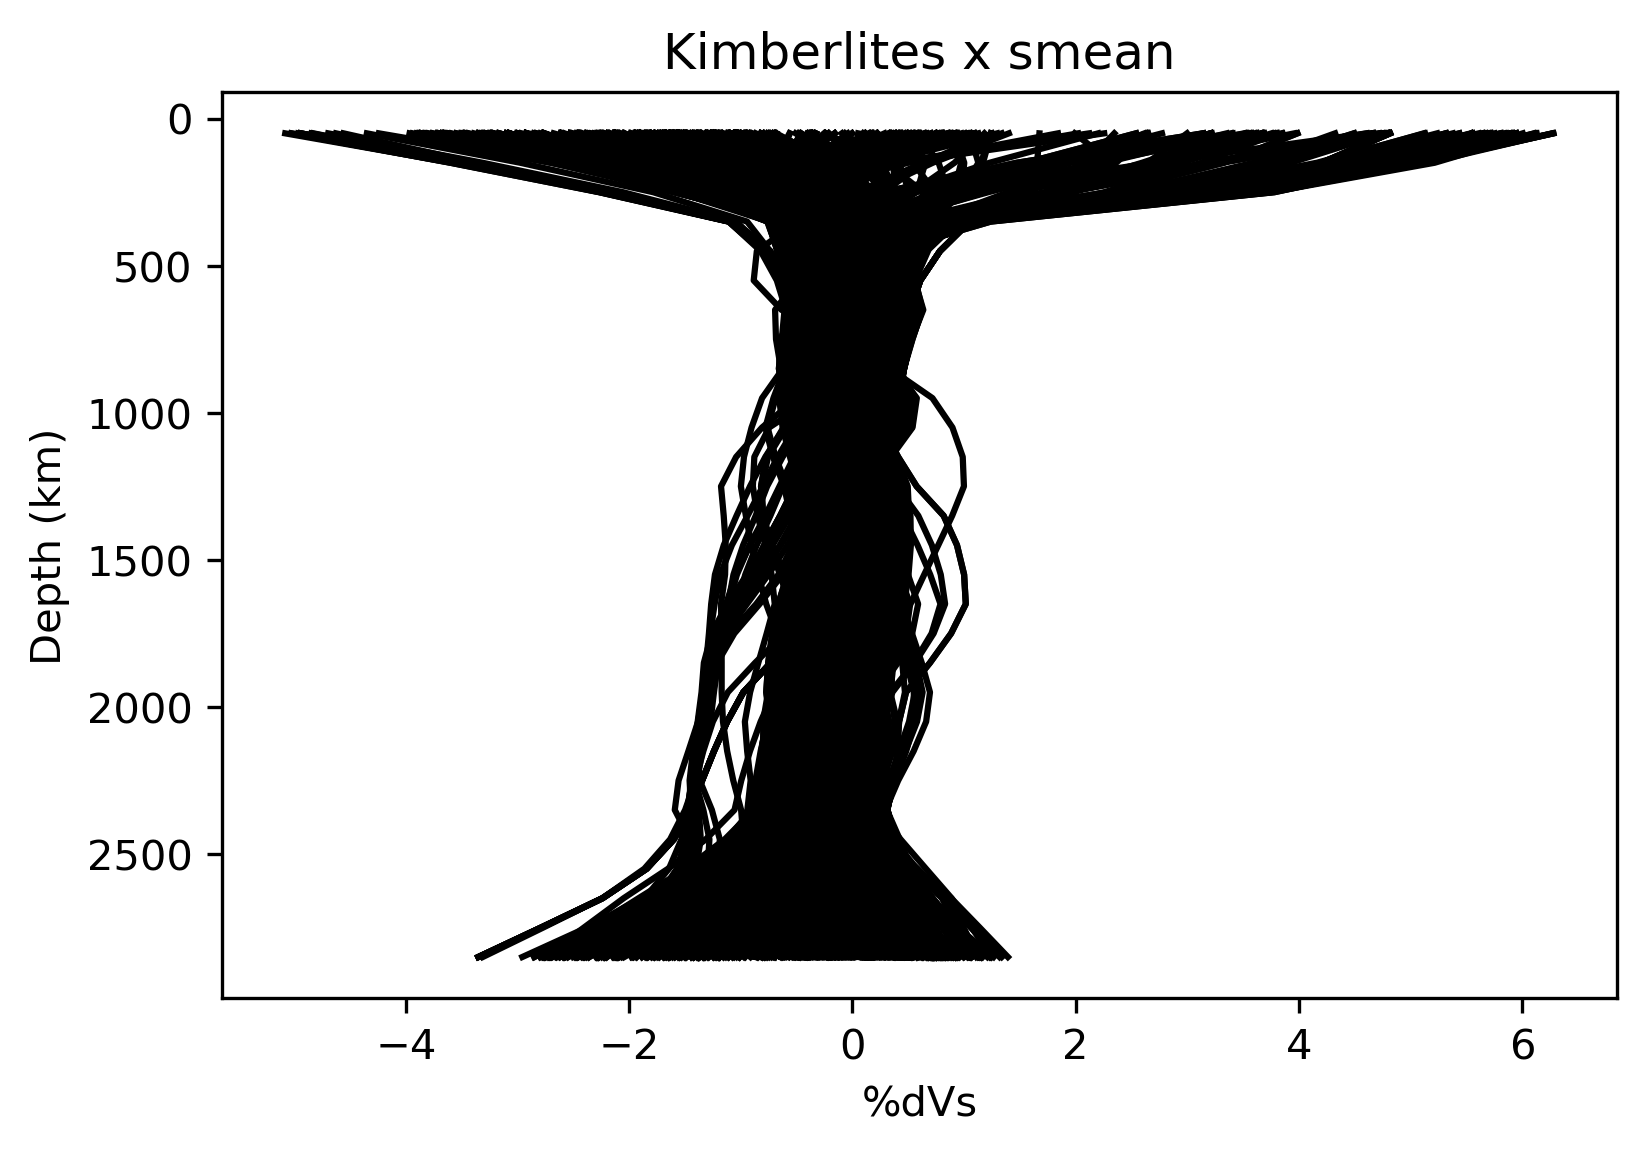

In [14]:
root='/Users/omer/Documents/CitcomS_Assim_Models/DeBeers_Packages/gld422/gld422_GPlates/NNR_InFiles/'

here= '/Users/omer/Documents/Programming/PyGplates/'
rotation_file1 = root + '1000-410_rotations-NNR.rot'
rotation_file2 = root + 'Global_EB_410-250Ma_GK07_2017-NNR.rot'
rotation_file3 = root + 'Global_EB_250-0Ma_GK07_2017-NNR.rot'
rotation_file4 = root + 'NR_0Ma_1000Ma_for_gplates.rot'

rotation_model = pygplates.RotationModel([rotation_file1,rotation_file2,rotation_file3,rotation_file4])

grid_dir='/Users/omer/Documents/Data_Tomography_Geology/Tomography_models/smean'



f=open('/Users/omer/Documents/Data_Tomography_Geology/Tomography_models/smean/smean_depths.txt','r')

DEPTHLIST=[]
for line in f:
    DEPTHLIST.append(line.strip())

step=-2

agemin=-2

agemina=agemin

agemax=200

agemaxa=agemax

anchor_plate_id=0

AllLats=[]
AllLons=[]
vs_at_p_all_depths_all_points_smean=[]
filenames = []
vs_at_p_all_depths_smean=[]

for age1 in xrange(agemax,agemin,step):
    
    age2 = age1+step # 1st iteration:330 Ma - 310 Ma
    age1f=float(age1)
    age2f=float(age2)
    ageofVtk=age1+step
    ageofVtkf=float(ageofVtk)
    
    
    # Start with an empty list of features that appear between age1 and age2 Ma.
#     features_to_modify = []
    
#     for feature in point_features:
#         name = feature.get_name()
#         begin_time, end_time = feature.get_valid_time()
     
#         if begin_time < age1f and begin_time >= age2f:
#             feature.set_valid_time(age1f, age2f)
#             features_to_modify.append(feature)
    
    
    Lons=[]
    Lats=[]
    numKimb=0
    for feature in point_features:
        
        point = feature.get_geometry()
        PlateID = feature.get_reconstruction_plate_id()
        BirthTime=feature.get_valid_time()[0]
        
        if BirthTime < age1f and BirthTime >= age2f:
            PlateRotation = rotation_model.get_rotation(ageofVtk, PlateID, anchor_plate_id)
            reconstructed_point = PlateRotation * point
            reconstructed_point_degrees = reconstructed_point.to_lat_lon_point()
            Lats.append(reconstructed_point_degrees.get_latitude())
            Lons.append(reconstructed_point_degrees.get_longitude())
            numKimb=numKimb+1
        
#             feature.set_valid_time(age1f, age2f)
            
#             features_to_modify.append(feature)
            
        
#         a,b= PlateRotation.get_euler_pole_and_angle()
#         print a,b," : are Euler Pole and Angle, resp."
#         reconstructed_point = PlateRotation * point.get_geometry()
#         reconstructed_point = PlateRotation * point
#         print point," is recons. to: ",reconstructed_point, " with PlateID", PlateID

    
    print numKimb, " kimberlites at ", ageofVtkf  

        
    AllLats.extend(Lats)
    AllLons.extend(Lons)
    


index=0    
for latitude in AllLats:
    vs_at_p_all_depths_smean=[]
    sayindex=1
    for depth in DEPTHLIST:
#     print depth
        tomo_pile_input_file = "%s/dvs.%d.grd" %(grid_dir, int(sayindex))  
           
        
#         print latitude
        vs_at_p_d = sample_using_gmt(tomo_pile_input_file, AllLons[index], latitude)
        
        vs_at_p_all_depths_smean.append(vs_at_p_d)
        sayindex=sayindex+1
        
    plt.plot(vs_at_p_all_depths_smean,np.asarray(DEPTHLIST,dtype="float64"),c='k')

    
    vs_at_p_all_depths_all_points_smean.append(vs_at_p_all_depths_smean)

    
#     Vs_mean_global_gypsum=np.append(Vs_mean_global,mean)
    index=index+1

    

    
#     vs_at_p_all_depths_all_points=[]
#     vs_at_p_all_depths=[]
    
plt.title('Kimberlites x smean')    
plt.gca().invert_yaxis()
plt.xlabel("%dVs")
plt.ylabel("Depth (km)")
plt.gca().figure.dpi=300    
plt.show()
    
        
# Elle=vs_at_p_all_depths_all_points.reshape(3,763)        
    
#     for p in features_to_modify:
    
#     #the code below uses pygplates to find point latitudes and longitudes
#     point = p.get_geometry()
#     ID=p.get_reconstruction_plate_id()
#     point_degrees = point.to_lat_lon_point()
#     point_lon = point_degrees.get_longitude()
#     point_lat = point_degrees.get_latitude()
#     eruptionTime= ageofVtkf
    
#     # reconstruct the point
#     #the code below finds the value of the tomography model at a given point and depth    
#     vs_at_p_all_depths =[]
#     for depth in DEPTHLIST:
#         tomo_pile_input_file = "%s/savani_%d.nc" %(grid_dir, int(depth))  
#         vs_at_p_d = sample_using_gmt(tomo_pile_input_file, point_lon, point_lat)
#         vs_at_p_all_depths.append(vs_at_p_d)
        
#     vs_at_p_all_depths_all_points.append(vs_at_p_all_depths)
    
    
    ##the list vs_at_p_all_depths_all_points should contain all 1-D profiles of Vs over depth
#     vs_at_p = sample_using_gmt(tomo_pile_input_file, point_lon, point_lat)
    
#     print(vs_at_p)

In [17]:
np.save("/Users/omer/Documents/Data_Tomography_Geology/Tomography_models/smean/KimberliteField_below_smean_Reconstructed_200Ma_0Ma.npy",
        np.asarray(vs_at_p_all_depths_all_points_smean,dtype="float64"))

In [ ]:
Kimberlites_Below_smean=np.load("/Users/omer/Documents/Data_Tomography_Geology/Tomography_models/smean/KimberliteField_below_smean_Reconstructed_320Ma_0Ma.npy")

In [ ]:
SEMUCB-WM1

In [ ]:
# SEMUCB-WM1

# smean2

2  kimberlites at  198.0
2  kimberlites at  196.0
2  kimberlites at  194.0
0  kimberlites at  192.0
2  kimberlites at  190.0
1  kimberlites at  188.0
1  kimberlites at  186.0
2  kimberlites at  184.0
4  kimberlites at  182.0
4  kimberlites at  180.0
2  kimberlites at  178.0
6  kimberlites at  176.0
4  kimberlites at  174.0
5  kimberlites at  172.0
8  kimberlites at  170.0
3  kimberlites at  168.0
0  kimberlites at  166.0
4  kimberlites at  164.0
2  kimberlites at  162.0
5  kimberlites at  160.0
6  kimberlites at  158.0
8  kimberlites at  156.0
8  kimberlites at  154.0
7  kimberlites at  152.0
9  kimberlites at  150.0
7  kimberlites at  148.0
15  kimberlites at  146.0
11  kimberlites at  144.0
6  kimberlites at  142.0
9  kimberlites at  140.0
13  kimberlites at  138.0
5  kimberlites at  136.0
14  kimberlites at  134.0
16  kimberlites at  132.0
7  kimberlites at  130.0
11  kimberlites at  128.0
10  kimberlites at  126.0
13  kimberlites at  124.0
7  kimberlites at  122.0
12  kimberlites a

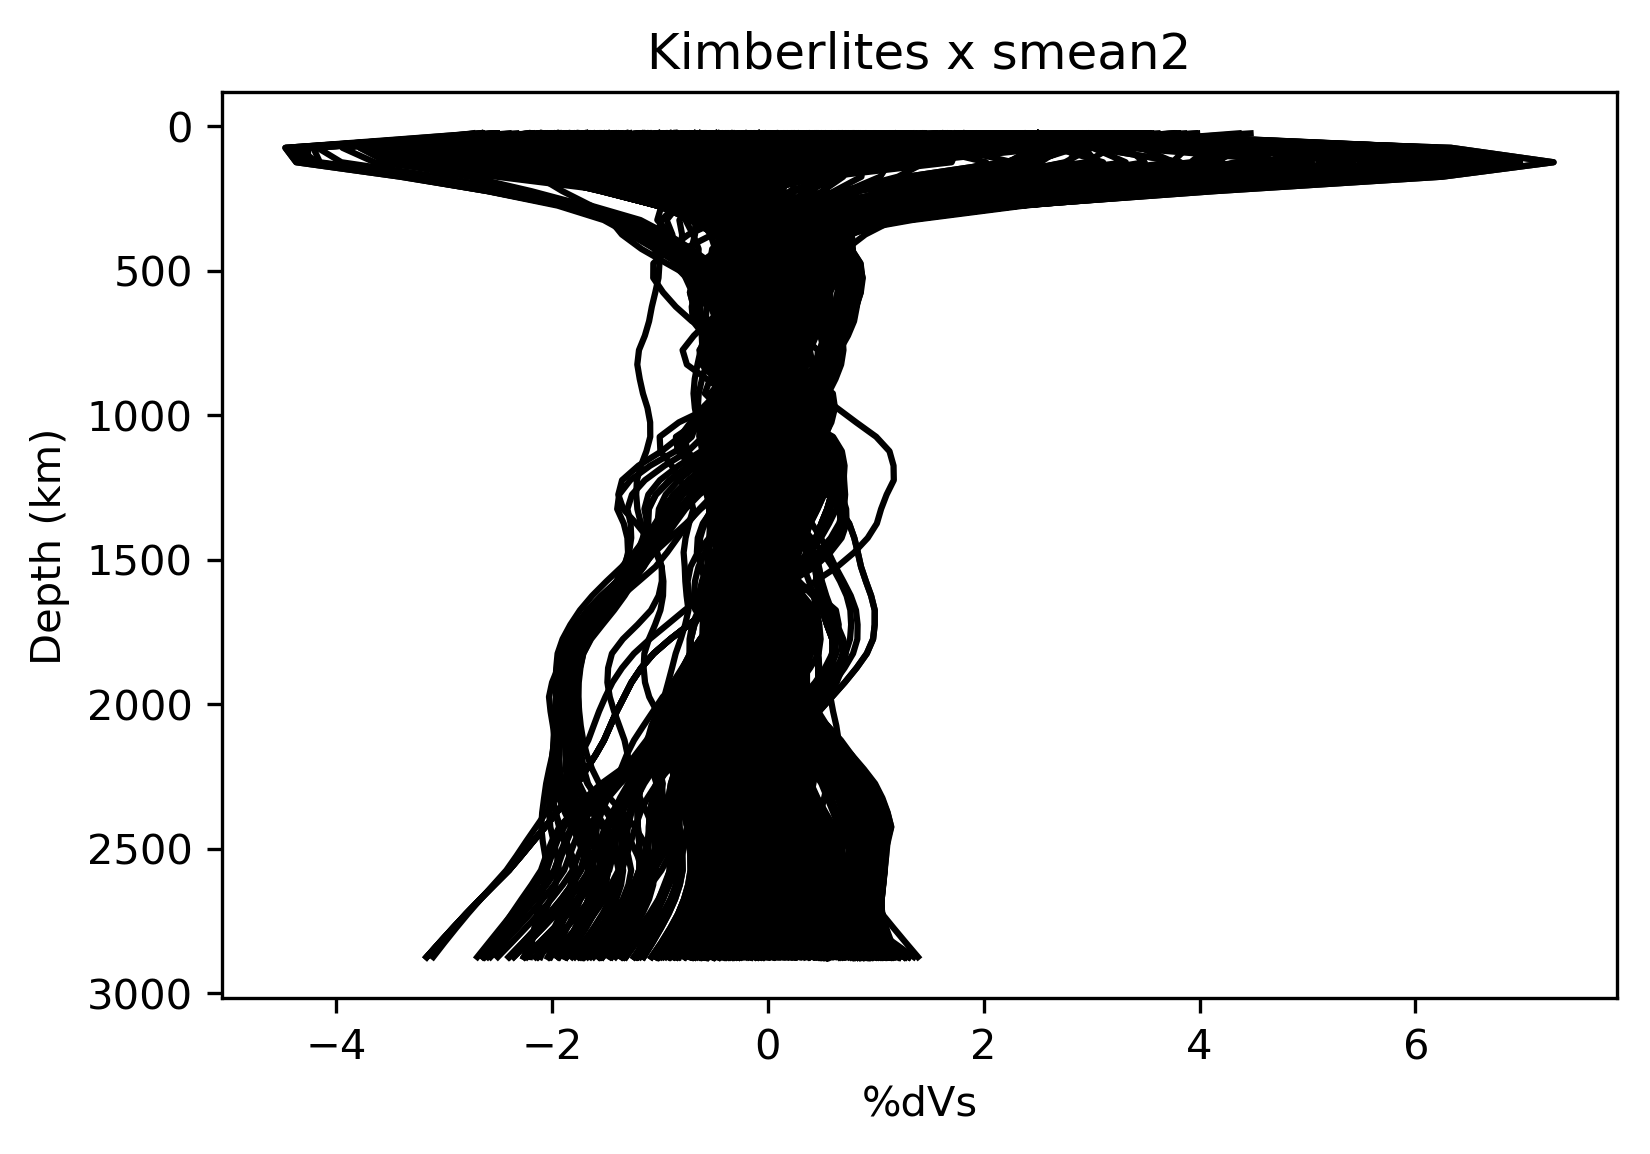

In [14]:
root='/Users/omer/Documents/CitcomS_Assim_Models/DeBeers_Packages/gld422/gld422_GPlates/NNR_InFiles/'

here= '/Users/omer/Documents/Programming/PyGplates/'
rotation_file1 = root + '1000-410_rotations-NNR.rot'
rotation_file2 = root + 'Global_EB_410-250Ma_GK07_2017-NNR.rot'
rotation_file3 = root + 'Global_EB_250-0Ma_GK07_2017-NNR.rot'
rotation_file4 = root + 'NR_0Ma_1000Ma_for_gplates.rot'

rotation_model = pygplates.RotationModel([rotation_file1,rotation_file2,rotation_file3,rotation_file4])

grid_dir='/Users/omer/Documents/Data_Tomography_Geology/Tomography_models/smean2'



f=open('/Users/omer/Documents/Data_Tomography_Geology/Tomography_models/smean2/smean2_depths.txt','r')

DEPTHLIST=[]
for line in f:
    DEPTHLIST.append(line.strip())

step=-2

agemin=-2

agemina=agemin

agemax=200

agemaxa=agemax

anchor_plate_id=0

AllLats=[]
AllLons=[]
vs_at_p_all_depths_all_points_smean2=[]
filenames = []
vs_at_p_all_depths_smean2=[]

for age1 in xrange(agemax,agemin,step):
    
    age2 = age1+step # 1st iteration:330 Ma - 310 Ma
    age1f=float(age1)
    age2f=float(age2)
    ageofVtk=age1+step
    ageofVtkf=float(ageofVtk)
    
    
    # Start with an empty list of features that appear between age1 and age2 Ma.
#     features_to_modify = []
    
#     for feature in point_features:
#         name = feature.get_name()
#         begin_time, end_time = feature.get_valid_time()
     
#         if begin_time < age1f and begin_time >= age2f:
#             feature.set_valid_time(age1f, age2f)
#             features_to_modify.append(feature)
    
    
    Lons=[]
    Lats=[]
    numKimb=0
    for feature in point_features:
        
        point = feature.get_geometry()
        PlateID = feature.get_reconstruction_plate_id()
        BirthTime=feature.get_valid_time()[0]
        
        if BirthTime < age1f and BirthTime >= age2f:
            PlateRotation = rotation_model.get_rotation(ageofVtk, PlateID, anchor_plate_id)
            reconstructed_point = PlateRotation * point
            reconstructed_point_degrees = reconstructed_point.to_lat_lon_point()
            Lats.append(reconstructed_point_degrees.get_latitude())
            Lons.append(reconstructed_point_degrees.get_longitude())
            numKimb=numKimb+1
        
#             feature.set_valid_time(age1f, age2f)
            
#             features_to_modify.append(feature)
            
        
#         a,b= PlateRotation.get_euler_pole_and_angle()
#         print a,b," : are Euler Pole and Angle, resp."
#         reconstructed_point = PlateRotation * point.get_geometry()
#         reconstructed_point = PlateRotation * point
#         print point," is recons. to: ",reconstructed_point, " with PlateID", PlateID

    
    print numKimb, " kimberlites at ", ageofVtkf  

        
    AllLats.extend(Lats)
    AllLons.extend(Lons)
    


index=0    
for latitude in AllLats:
    vs_at_p_all_depths_smean2=[]
    sayindex=1
    for depth in DEPTHLIST:
#     print depth
        tomo_pile_input_file = "%s/dvs.%d.grd" %(grid_dir, int(sayindex))  
           
        
#         print latitude
        vs_at_p_d = sample_using_gmt(tomo_pile_input_file, AllLons[index], latitude)
        
        vs_at_p_all_depths_smean2.append(vs_at_p_d)
        sayindex=sayindex+1
        
    plt.plot(vs_at_p_all_depths_smean2,np.asarray(DEPTHLIST,dtype="float64"),c='k')

    
    vs_at_p_all_depths_all_points_smean2.append(vs_at_p_all_depths_smean2)

    
#     Vs_mean_global_gypsum=np.append(Vs_mean_global,mean)
    index=index+1

    

    
#     vs_at_p_all_depths_all_points=[]
#     vs_at_p_all_depths=[]
    
plt.title('Kimberlites x smean2')    
plt.gca().invert_yaxis()
plt.xlabel("%dVs")
plt.ylabel("Depth (km)")
plt.gca().figure.dpi=300    
plt.show()
    
        
# Elle=vs_at_p_all_depths_all_points.reshape(3,763)        
    
#     for p in features_to_modify:
    
#     #the code below uses pygplates to find point latitudes and longitudes
#     point = p.get_geometry()
#     ID=p.get_reconstruction_plate_id()
#     point_degrees = point.to_lat_lon_point()
#     point_lon = point_degrees.get_longitude()
#     point_lat = point_degrees.get_latitude()
#     eruptionTime= ageofVtkf
    
#     # reconstruct the point
#     #the code below finds the value of the tomography model at a given point and depth    
#     vs_at_p_all_depths =[]
#     for depth in DEPTHLIST:
#         tomo_pile_input_file = "%s/savani_%d.nc" %(grid_dir, int(depth))  
#         vs_at_p_d = sample_using_gmt(tomo_pile_input_file, point_lon, point_lat)
#         vs_at_p_all_depths.append(vs_at_p_d)
        
#     vs_at_p_all_depths_all_points.append(vs_at_p_all_depths)
    
    
    ##the list vs_at_p_all_depths_all_points should contain all 1-D profiles of Vs over depth
#     vs_at_p = sample_using_gmt(tomo_pile_input_file, point_lon, point_lat)
    
#     print(vs_at_p)

In [15]:
np.save("/Users/omer/Documents/Data_Tomography_Geology/Tomography_models/smean2/KimberliteField_below_smean2_Reconstructed_200Ma_0Ma.npy",
        np.asarray(vs_at_p_all_depths_all_points_smean2,dtype="float64"))

2  kimberlites at  198.0
2  kimberlites at  196.0
2  kimberlites at  194.0
0  kimberlites at  192.0
2  kimberlites at  190.0
1  kimberlites at  188.0
1  kimberlites at  186.0
2  kimberlites at  184.0
4  kimberlites at  182.0
4  kimberlites at  180.0
2  kimberlites at  178.0
6  kimberlites at  176.0
4  kimberlites at  174.0
5  kimberlites at  172.0
8  kimberlites at  170.0
3  kimberlites at  168.0
0  kimberlites at  166.0
4  kimberlites at  164.0
2  kimberlites at  162.0
5  kimberlites at  160.0
6  kimberlites at  158.0
8  kimberlites at  156.0
8  kimberlites at  154.0
7  kimberlites at  152.0
9  kimberlites at  150.0
7  kimberlites at  148.0
15  kimberlites at  146.0
11  kimberlites at  144.0
6  kimberlites at  142.0
9  kimberlites at  140.0
13  kimberlites at  138.0
5  kimberlites at  136.0
14  kimberlites at  134.0
16  kimberlites at  132.0
7  kimberlites at  130.0
11  kimberlites at  128.0
10  kimberlites at  126.0
13  kimberlites at  124.0
7  kimberlites at  122.0
12  kimberlites a

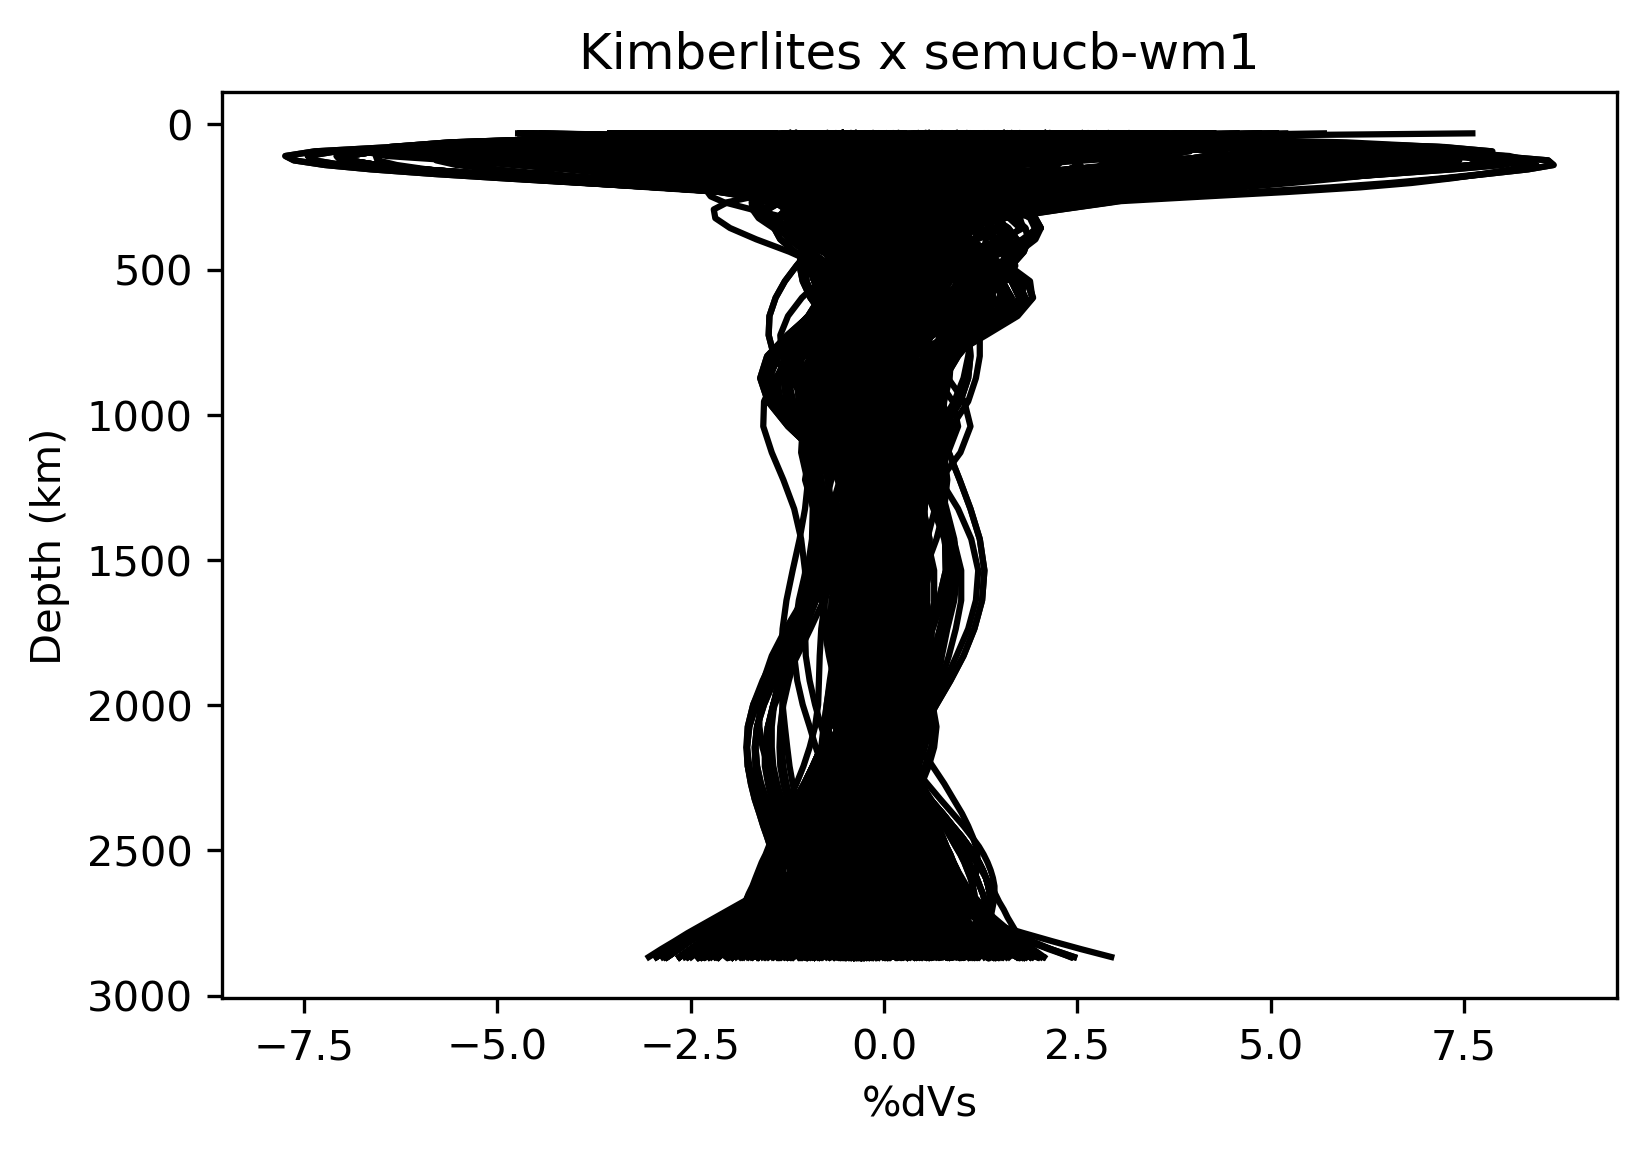

In [10]:
root='/Users/omer/Documents/CitcomS_Assim_Models/DeBeers_Packages/gld422/gld422_GPlates/NNR_InFiles/'

here= '/Users/omer/Documents/Programming/PyGplates/'
rotation_file1 = root + '1000-410_rotations-NNR.rot'
rotation_file2 = root + 'Global_EB_410-250Ma_GK07_2017-NNR.rot'
rotation_file3 = root + 'Global_EB_250-0Ma_GK07_2017-NNR.rot'
rotation_file4 = root + 'NR_0Ma_1000Ma_for_gplates.rot'

rotation_model = pygplates.RotationModel([rotation_file1,rotation_file2,rotation_file3,rotation_file4])

grid_dir='/Users/omer/Documents/Data_Tomography_Geology/Tomography_models/SEMUCB-WM1/Tomography'



f=open('/Users/omer/Documents/Data_Tomography_Geology/semucb-wm1_depths.txt','r')

DEPTHLIST=[]
for line in f:
    DEPTHLIST.append(line.strip())

step=-2

agemin=-2

agemina=agemin

agemax=200

agemaxa=agemax

anchor_plate_id=0

AllLats=[]
AllLons=[]
vs_at_p_all_depths_all_points_semucb_wm1=[]
filenames = []
vs_at_p_all_depths_semucb_wm1=[]

for age1 in xrange(agemax,agemin,step):
    
    age2 = age1+step # 1st iteration:330 Ma - 310 Ma
    age1f=float(age1)
    age2f=float(age2)
    ageofVtk=age1+step
    ageofVtkf=float(ageofVtk)
    
    
    # Start with an empty list of features that appear between age1 and age2 Ma.
#     features_to_modify = []
    
#     for feature in point_features:
#         name = feature.get_name()
#         begin_time, end_time = feature.get_valid_time()
     
#         if begin_time < age1f and begin_time >= age2f:
#             feature.set_valid_time(age1f, age2f)
#             features_to_modify.append(feature)
    
    
    Lons=[]
    Lats=[]
    numKimb=0
    for feature in point_features:
        
        point = feature.get_geometry()
        PlateID = feature.get_reconstruction_plate_id()
        BirthTime=feature.get_valid_time()[0]
        
        if BirthTime < age1f and BirthTime >= age2f:
            PlateRotation = rotation_model.get_rotation(ageofVtk, PlateID, anchor_plate_id)
            reconstructed_point = PlateRotation * point
            reconstructed_point_degrees = reconstructed_point.to_lat_lon_point()
            Lats.append(reconstructed_point_degrees.get_latitude())
            Lons.append(reconstructed_point_degrees.get_longitude())
            numKimb=numKimb+1
        
#             feature.set_valid_time(age1f, age2f)
            
#             features_to_modify.append(feature)
            
        
#         a,b= PlateRotation.get_euler_pole_and_angle()
#         print a,b," : are Euler Pole and Angle, resp."
#         reconstructed_point = PlateRotation * point.get_geometry()
#         reconstructed_point = PlateRotation * point
#         print point," is recons. to: ",reconstructed_point, " with PlateID", PlateID

    
    print numKimb, " kimberlites at ", ageofVtkf  

        
    AllLats.extend(Lats)
    AllLons.extend(Lons)
    


index=0    
for latitude in AllLats:
    vs_at_p_all_depths_semucb_wm1=[]
    sayindex=1
    for depth in DEPTHLIST:
#     print depth
        tomo_pile_input_file = "%s/SEMUCB-WM1_%d.nc" %(grid_dir, int(depth))  
           
        
#         print latitude
        vs_at_p_d = sample_using_gmt(tomo_pile_input_file, AllLons[index], latitude)
        
        vs_at_p_all_depths_semucb_wm1.append(vs_at_p_d)
        sayindex=sayindex+1
        
    plt.plot(vs_at_p_all_depths_semucb_wm1,np.asarray(DEPTHLIST,dtype="float64"),c='k')

    
    vs_at_p_all_depths_all_points_semucb_wm1.append(vs_at_p_all_depths_semucb_wm1)

    
#     Vs_mean_global_gypsum=np.append(Vs_mean_global,mean)
    index=index+1

    

    
#     vs_at_p_all_depths_all_points=[]
#     vs_at_p_all_depths=[]
    
plt.title('Kimberlites x semucb-wm1')    
plt.gca().invert_yaxis()
plt.xlabel("%dVs")
plt.ylabel("Depth (km)")
plt.gca().figure.dpi=300    
plt.show()
    
        
# Elle=vs_at_p_all_depths_all_points.reshape(3,763)        
    
#     for p in features_to_modify:
    
#     #the code below uses pygplates to find point latitudes and longitudes
#     point = p.get_geometry()
#     ID=p.get_reconstruction_plate_id()
#     point_degrees = point.to_lat_lon_point()
#     point_lon = point_degrees.get_longitude()
#     point_lat = point_degrees.get_latitude()
#     eruptionTime= ageofVtkf
    
#     # reconstruct the point
#     #the code below finds the value of the tomography model at a given point and depth    
#     vs_at_p_all_depths =[]
#     for depth in DEPTHLIST:
#         tomo_pile_input_file = "%s/savani_%d.nc" %(grid_dir, int(depth))  
#         vs_at_p_d = sample_using_gmt(tomo_pile_input_file, point_lon, point_lat)
#         vs_at_p_all_depths.append(vs_at_p_d)
        
#     vs_at_p_all_depths_all_points.append(vs_at_p_all_depths)
    
    
    ##the list vs_at_p_all_depths_all_points should contain all 1-D profiles of Vs over depth
#     vs_at_p = sample_using_gmt(tomo_pile_input_file, point_lon, point_lat)
    
#     print(vs_at_p)

In [11]:
np.save("/Users/omer/Documents/Data_Tomography_Geology/Tomography_models/SEMUCB-WM1/Tomography/KimberliteField_below_semucb_wm1_Reconstructed_200Ma_0Ma.npy",
        np.asarray(vs_at_p_all_depths_all_points_semucb_wm1,dtype="float64"))

In [ ]:
Kimberlites_Below_semucb_wm1=np.load("/Users/omer/Documents/Data_Tomography_Geology/Tomography_models/SEMUCB-WM1/Tomography/KimberliteField_below_semucb_wm1_Reconstructed_320Ma_0Ma.npy")

# HMSL.S

2  kimberlites at  198.0
2  kimberlites at  196.0
2  kimberlites at  194.0
0  kimberlites at  192.0
2  kimberlites at  190.0
1  kimberlites at  188.0
1  kimberlites at  186.0
2  kimberlites at  184.0
4  kimberlites at  182.0
4  kimberlites at  180.0
2  kimberlites at  178.0
6  kimberlites at  176.0
4  kimberlites at  174.0
5  kimberlites at  172.0
8  kimberlites at  170.0
3  kimberlites at  168.0
0  kimberlites at  166.0
4  kimberlites at  164.0
2  kimberlites at  162.0
5  kimberlites at  160.0
6  kimberlites at  158.0
8  kimberlites at  156.0
8  kimberlites at  154.0
7  kimberlites at  152.0
9  kimberlites at  150.0
7  kimberlites at  148.0
15  kimberlites at  146.0
11  kimberlites at  144.0
6  kimberlites at  142.0
9  kimberlites at  140.0
13  kimberlites at  138.0
5  kimberlites at  136.0
14  kimberlites at  134.0
16  kimberlites at  132.0
7  kimberlites at  130.0
11  kimberlites at  128.0
10  kimberlites at  126.0
13  kimberlites at  124.0
7  kimberlites at  122.0
12  kimberlites a

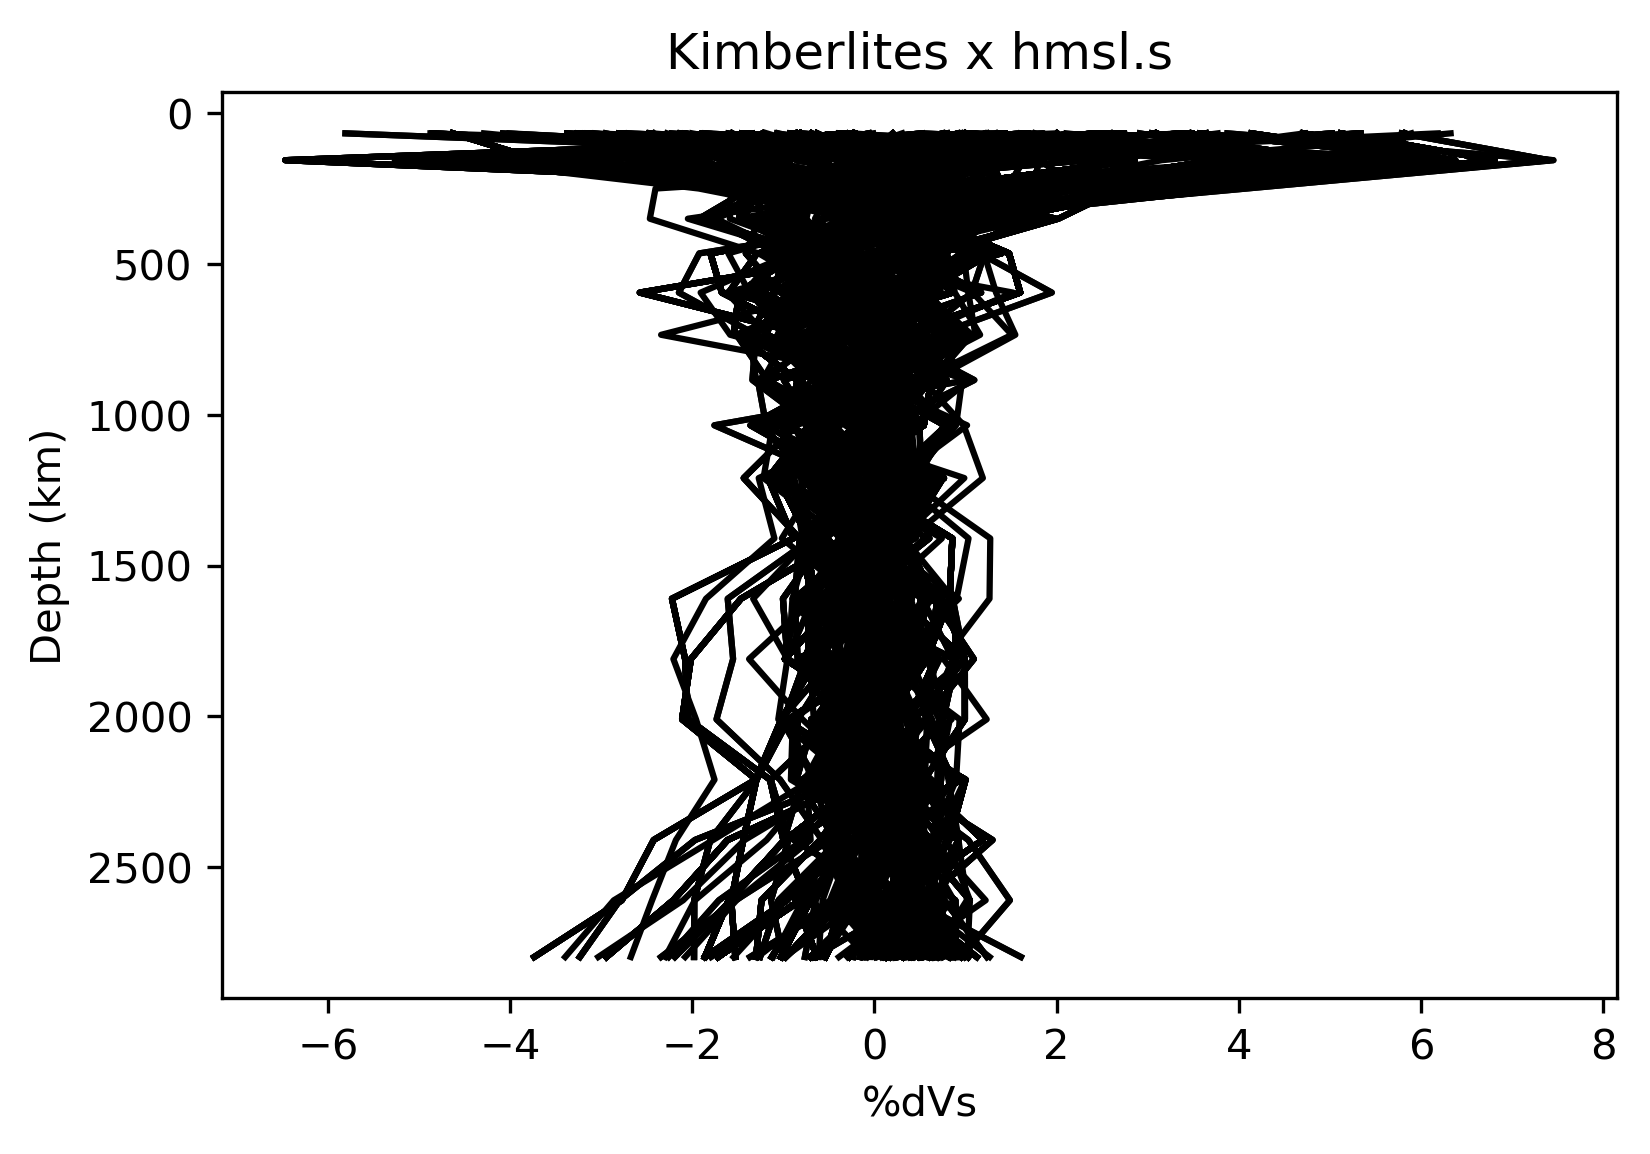

In [5]:
root='/Users/omer/Documents/CitcomS_Assim_Models/DeBeers_Packages/gld422/gld422_GPlates/NNR_InFiles/'

here= '/Users/omer/Documents/Programming/PyGplates/'
rotation_file1 = root + '1000-410_rotations-NNR.rot'
rotation_file2 = root + 'Global_EB_410-250Ma_GK07_2017-NNR.rot'
rotation_file3 = root + 'Global_EB_250-0Ma_GK07_2017-NNR.rot'
rotation_file4 = root + 'NR_0Ma_1000Ma_for_gplates.rot'

rotation_model = pygplates.RotationModel([rotation_file1,rotation_file2,rotation_file3,rotation_file4])

grid_dir='/Users/omer/Documents/Data_Tomography_Geology/Tomography_models/HMSL.S/Tomography'



f=open('/Users/omer/Documents/Data_Tomography_Geology/HMSL_S_depths.txt','r')

DEPTHLIST=[]
for line in f:
    DEPTHLIST.append(line.strip())

step=-2

agemin=-2

agemina=agemin

agemax=200

agemaxa=agemax

anchor_plate_id=0

AllLats=[]
AllLons=[]
vs_at_p_all_depths_all_points_hmsl_s=[]
filenames = []
vs_at_p_all_depths_hmsl_s=[]

for age1 in xrange(agemax,agemin,step):
    
    age2 = age1+step # 1st iteration:330 Ma - 310 Ma
    age1f=float(age1)
    age2f=float(age2)
    ageofVtk=age1+step
    ageofVtkf=float(ageofVtk)
    
    
    # Start with an empty list of features that appear between age1 and age2 Ma.
#     features_to_modify = []
    
#     for feature in point_features:
#         name = feature.get_name()
#         begin_time, end_time = feature.get_valid_time()
     
#         if begin_time < age1f and begin_time >= age2f:
#             feature.set_valid_time(age1f, age2f)
#             features_to_modify.append(feature)
    
    
    Lons=[]
    Lats=[]
    numKimb=0
    for feature in point_features:
        
        point = feature.get_geometry()
        PlateID = feature.get_reconstruction_plate_id()
        BirthTime=feature.get_valid_time()[0]
        
        if BirthTime < age1f and BirthTime >= age2f:
            PlateRotation = rotation_model.get_rotation(ageofVtk, PlateID, anchor_plate_id)
            reconstructed_point = PlateRotation * point
            reconstructed_point_degrees = reconstructed_point.to_lat_lon_point()
            Lats.append(reconstructed_point_degrees.get_latitude())
            Lons.append(reconstructed_point_degrees.get_longitude())
            numKimb=numKimb+1
        
#             feature.set_valid_time(age1f, age2f)
            
#             features_to_modify.append(feature)
            
        
#         a,b= PlateRotation.get_euler_pole_and_angle()
#         print a,b," : are Euler Pole and Angle, resp."
#         reconstructed_point = PlateRotation * point.get_geometry()
#         reconstructed_point = PlateRotation * point
#         print point," is recons. to: ",reconstructed_point, " with PlateID", PlateID

    
    print numKimb, " kimberlites at ", ageofVtkf  

        
    AllLats.extend(Lats)
    AllLons.extend(Lons)
    


index=0    
for latitude in AllLats:
    vs_at_p_all_depths_hmsl_s=[]
    sayindex=1
    for depth in DEPTHLIST:
#     print depth
        tomo_pile_input_file = "%s/HMSL.S_%d.nc" %(grid_dir, int(depth))  
           
        
#         print latitude
        vs_at_p_d = sample_using_gmt(tomo_pile_input_file, AllLons[index], latitude)
        
        vs_at_p_all_depths_hmsl_s.append(vs_at_p_d)
        sayindex=sayindex+1
        
    plt.plot(vs_at_p_all_depths_hmsl_s,np.asarray(DEPTHLIST,dtype="float64"),c='k')

    
    vs_at_p_all_depths_all_points_hmsl_s.append(vs_at_p_all_depths_hmsl_s)

    
#     Vs_mean_global_gypsum=np.append(Vs_mean_global,mean)
    index=index+1

    

    
#     vs_at_p_all_depths_all_points=[]
#     vs_at_p_all_depths=[]
    
plt.title('Kimberlites x hmsl.s')    
plt.gca().invert_yaxis()
plt.xlabel("%dVs")
plt.ylabel("Depth (km)")
plt.gca().figure.dpi=300    
plt.show()
    
        
# Elle=vs_at_p_all_depths_all_points.reshape(3,763)        
    
#     for p in features_to_modify:
    
#     #the code below uses pygplates to find point latitudes and longitudes
#     point = p.get_geometry()
#     ID=p.get_reconstruction_plate_id()
#     point_degrees = point.to_lat_lon_point()
#     point_lon = point_degrees.get_longitude()
#     point_lat = point_degrees.get_latitude()
#     eruptionTime= ageofVtkf
    
#     # reconstruct the point
#     #the code below finds the value of the tomography model at a given point and depth    
#     vs_at_p_all_depths =[]
#     for depth in DEPTHLIST:
#         tomo_pile_input_file = "%s/savani_%d.nc" %(grid_dir, int(depth))  
#         vs_at_p_d = sample_using_gmt(tomo_pile_input_file, point_lon, point_lat)
#         vs_at_p_all_depths.append(vs_at_p_d)
        
#     vs_at_p_all_depths_all_points.append(vs_at_p_all_depths)
    
    
    ##the list vs_at_p_all_depths_all_points should contain all 1-D profiles of Vs over depth
#     vs_at_p = sample_using_gmt(tomo_pile_input_file, point_lon, point_lat)
    
#     print(vs_at_p)

In [6]:
np.save("/Users/omer/Documents/Data_Tomography_Geology/Tomography_models/HMSL.S/Tomography/KimberliteField_below_HMSL_S_Reconstructed_200Ma_0Ma.npy",
        np.asarray(vs_at_p_all_depths_all_points_hmsl_s,dtype="float64"))

In [ ]:
Kimberlites_Below_hmsl_s=np.load("/Users/omer/Documents/Data_Tomography_Geology/Tomography_models/HMSL.S/Tomography/KimberliteField_below_HMSL_S_Reconstructed_320Ma_0Ma.npy")

In [ ]:
f=open('/Users/omer/Documents/Data_Tomography_Geology/savani_depths.txt','r')

DEPTHLIST=[]
for line in f:
    DEPTHLIST.append(line.strip())
plt.close()
# plt.plot(MyDataFrame.mean(),np.asarray(DEPTHLIST,dtype="float64"), label="Kimberlites 0-320 Ma (Savani)")
# plt.errorbar(MyDataFrame.mean(),np.asarray(DEPTHLIST,dtype="float64"), 
#              xerr=MyDataFrame.std(),label="Kimberlites with std 0-320 Ma (Savani)")


plt.plot(MyDataFrame.mean(),np.asarray(DEPTHLIST,dtype="float64"),label="Kimberlites 0-320 Ma (Savani)",c="orange")


plt.plot(SavaniMean,np.asarray(DEPTHLIST,dtype="float64"),"--",label="Savani Global Average",c="orange")

f=open('/Users/omer/Documents/Data_Tomography_Geology/GypsumS_depths.txt','r')

DEPTHLIST=[]
for line in f:
    DEPTHLIST.append(line.strip())

    
    
# plt.errorbar(MyDataFrameGypsum.mean(),np.asarray(DEPTHLIST,dtype="float64"), 
#              xerr=MyDataFrameGypsum.std(),label="Kimberlites with std 0-320 Ma (GypsumS)")


plt.plot(MyDataFrameGypsum.mean(),np.asarray(DEPTHLIST,dtype="float64"),label="Kimberlites 0-320 Ma (GypsumS)",c="k")

plt.plot(GypsumS_Mean,np.asarray(DEPTHLIST,dtype="float64"),"--",label="GypsumS Global Average",c="k")



f=open('/Users/omer/Documents/Data_Tomography_Geology/s40rts_depths.txt','r')

DEPTHLIST=[]
for line in f:
    DEPTHLIST.append(line.strip())



plt.plot(MyDataFrame_s40rts.mean(),np.asarray(DEPTHLIST,dtype="float64"),label="Kimberlites 0-320 Ma (s40rts)",c="blue")

plt.plot(s40rts_Mean,np.asarray(DEPTHLIST,dtype="float64"),"--",label="s40rts Global Average",c="blue")

plt.plot()
plt.plot()
plt.gca().invert_yaxis()
plt.xlabel("%dVs")
plt.ylabel("Depth (km)")
plt.gca().figure.dpi=300
plt.ylim(3000,500)
plt.xlim(-1.,1.)
plt.legend()
plt.grid()
plt.show()
    

In [ ]:
8+2+5+ 13+ 30  + 14 +19 +37 + 52 +103 + 95 +120  +166 + 83 + 11 + 3 + 1 

In [ ]:
np.asarray(vs_at_p_all_depths_all_points).shape

In [ ]:
vs_at_p_all_depths_all_points

In [ ]:
New=np.asarray(vs_at_p_all_depths_all_points,dtype="float64").reshape(762,len(DEPTHLIST))

In [ ]:
# Newdf.mean()
New[0].shape

In [ ]:
Newdf=pd.DataFrame(New)

In [ ]:
# vs_at_p_all_depths_all_points

dd=np.asarray(vs_at_p_all_depths_all_points,dtype="float64")
plt.close()
for index in range(0,762,1): #12971
    
    plt.plot(New[index],np.asarray(DEPTHLIST,dtype="float64"),linewidth=0.3, alpha=0.3)

plt.plot(Newdf.mean(),np.asarray(DEPTHLIST,dtype="float64"),linewidth=2,c='black')

plt.gca().invert_yaxis()
plt.xlabel("%dVs")
plt.ylabel("Depth (km)")
plt.gca().figure.dpi=300
# plt.xlim(-4.0,4.0)
# plt.ylim(2900,500)
# plt.title("Plate ID: "+str(IDs[0]))
plt.show()

In [ ]:
Newdf=pd.DataFrame(New)

In [ ]:
Newdf.mean()

In [ ]:
for p in point_features:
    
    #the code below uses pygplates to find point latitudes and longitudes
    point = p.get_geometry()
    ID=p.get_reconstruction_plate_id()
    point_degrees = point.to_lat_lon_point()
    point_lon = point_degrees.get_longitude()
    point_lat = point_degrees.get_latitude()
    eruptionTime= p.
    #the code below finds the value of the tomography model at a given point and depth
    if ()
    vs_at_p_all_depths =[]
    for depth in DEPTHLIST:
        tomo_pile_input_file = "%s/savani_%d.nc" %(grid_dir, int(depth))  
        vs_at_p_d = sample_using_gmt(tomo_pile_input_file, point_lon, point_lat)
        vs_at_p_all_depths.append(vs_at_p_d)
        
    vs_at_p_all_depths_all_points.append(vs_at_p_all_depths)

In [ ]:
for depth in DEPTHLIST[0:3]:
    print depth

# Compute the means

In [6]:
s40rts_Mean=[]
s40rts_STD=[]
grid_dir='/Users/omer/Documents/Data_Tomography_Geology/Tomography_models/s40rts/Tomography/'

f=open('/Users/omer/Documents/Data_Tomography_Geology/s40rts_depths.txt','r')
DEPTHLIST=[]
for line in f:
    DEPTHLIST.append(line.strip())
for depth in DEPTHLIST:
#     print depth
    tomo_pile_input_file = "%s/s40rts_%d.nc" %(grid_dir, int(depth))  

    mean=float(call_system_command(['gmt',

                         'grdinfo',

                         '-Cn',

                         '-L2',

                         '-o10',

                         '%s' % tomo_pile_input_file],

                          return_stdout=True))

    s40rts_Mean.append(mean)
    std=float(call_system_command(['gmt',

                     'grdinfo',

                     '-Cn',

                     '-L2',

                     '-o11',

                     '%s' % tomo_pile_input_file],

                      return_stdout=True))

    s40rts_STD.append(std)
    
    
grid_dir='/Users/omer/Documents/Data_Tomography_Geology/Tomography_models/GypsumS/Tomography/'

f=open('/Users/omer/Documents/Data_Tomography_Geology/GypsumS_depths.txt','r')

DEPTHLIST=[]
for line in f:
    DEPTHLIST.append(line.strip())

GypsumS_Mean=[]
GypsumS_STD=[]
for depth in DEPTHLIST:
#     print depth
    tomo_pile_input_file = "%s/GypsumS_%d.nc" %(grid_dir, int(depth))  
           
        

    mean=float(call_system_command(['gmt',

                         'grdinfo',

                         '-Cn',

                         '-L2',

                         '-o10',

                         '%s' % tomo_pile_input_file],

                          return_stdout=True))

    GypsumS_Mean.append(mean)
    
    std=float(call_system_command(['gmt',

                     'grdinfo',

                     '-Cn',

                     '-L2',

                     '-o11',

                     '%s' % tomo_pile_input_file],

                      return_stdout=True))

    GypsumS_STD.append(std)
    
    
grid_dir='/Users/omer/Documents/Data_Tomography_Geology/Tomography_models/savani/Tomography/'

f=open('/Users/omer/Documents/Data_Tomography_Geology/savani_depths.txt','r')

DEPTHLIST=[]
for line in f:
    DEPTHLIST.append(line.strip())

SavaniMean=[]
Savani_STD=[]
for depth in DEPTHLIST:
#     print depth
    tomo_pile_input_file = "%s/savani_%d.nc" %(grid_dir, int(depth))  
           
        

    mean=float(call_system_command(['gmt',

                         'grdinfo',

                         '-Cn',

                         '-L2',

                         '-o10',

                         '%s' % tomo_pile_input_file],

                          return_stdout=True))

    SavaniMean.append(mean)
    
    std=float(call_system_command(['gmt',

                     'grdinfo',

                     '-Cn',

                     '-L2',

                     '-o11',

                     '%s' % tomo_pile_input_file],

                      return_stdout=True))

    Savani_STD.append(std)
    

# grid_dir='/Users/omer/Documents/Data_Tomography_Geology/Tomography_models/HMSL.S/Tomography'

# f=open('/Users/omer/Documents/Data_Tomography_Geology/HMSL_S_depths.txt','r')

# DEPTHLIST=[]
# for line in f:
#     DEPTHLIST.append(line.strip())

# hmsl_s_Mean=[]
# hmsl_s_STD=[]
# for depth in DEPTHLIST:
# #     print depth
#     tomo_pile_input_file = "%s/HMSL.S_%d.nc" %(grid_dir, int(depth))  
           
        

#     mean=float(call_system_command(['gmt',

#                          'grdinfo',

#                          '-Cn',

#                          '-L2',

#                          '-o10',

#                          '%s' % tomo_pile_input_file],

#                           return_stdout=True))

#     hmsl_s_Mean.append(mean)
    
#     std=float(call_system_command(['gmt',

#                      'grdinfo',

#                      '-Cn',

#                      '-L2',

#                      '-o11',

#                      '%s' % tomo_pile_input_file],

#                       return_stdout=True))

#     hmsl_s_STD.append(std)

grid_dir='/Users/omer/Documents/Data_Tomography_Geology/Tomography_models/SEMUCB-WM1/Tomography'

f=open('/Users/omer/Documents/Data_Tomography_Geology/semucb-wm1_depths.txt','r')

DEPTHLIST=[]
for line in f:
    DEPTHLIST.append(line.strip())

semucb_wm1_Mean=[]
semucb_wm1_STD=[]
for depth in DEPTHLIST:
#     print depth
    tomo_pile_input_file = "%s/SEMUCB-WM1_%d.nc" %(grid_dir, int(depth))  
           
        

    mean=float(call_system_command(['gmt',

                         'grdinfo',

                         '-Cn',

                         '-L2',

                         '-o10',

                         '%s' % tomo_pile_input_file],

                          return_stdout=True))

    semucb_wm1_Mean.append(mean)
    
    std=float(call_system_command(['gmt',

                     'grdinfo',

                     '-Cn',

                     '-L2',

                     '-o11',

                     '%s' % tomo_pile_input_file],

                      return_stdout=True))

    semucb_wm1_STD.append(std)   
    
# grid_dir='/Users/omer/Documents/Data_Tomography_Geology/Tomography_models/smean'

# f=open('/Users/omer/Documents/Data_Tomography_Geology/Tomography_models/smean/smean_depths.txt','r')

# DEPTHLIST=[]
# for line in f:
#     DEPTHLIST.append(line.strip())
    
    
# smean_Mean=[]
# smean_STD=[]
# sayindex=1
# for depth in DEPTHLIST:
# #     print depth
    
#     tomo_pile_input_file = "%s/dvs.%d.grd" %(grid_dir, int(sayindex))  
           
        

#     mean=float(call_system_command(['gmt',

#                          'grdinfo',

#                          '-Cn',

#                          '-L2',

#                          '-o10',

#                          '%s' % tomo_pile_input_file],

#                           return_stdout=True))

#     smean_Mean.append(mean)
    
    
#     std=float(call_system_command(['gmt',

#                      'grdinfo',

#                      '-Cn',

#                      '-L2',

#                      '-o11',

#                      '%s' % tomo_pile_input_file],

#                       return_stdout=True))

#     smean_STD.append(std)  
#     sayindex=sayindex+1

# grid_dir='/Users/omer/Documents/Data_Tomography_Geology/Tomography_models/smean2'

# f=open('/Users/omer/Documents/Data_Tomography_Geology/Tomography_models/smean2/smean2_depths.txt','r')

# DEPTHLIST=[]
# for line in f:
#     DEPTHLIST.append(line.strip())
        
    
# smean2_Mean=[]
# smean2_STD=[]
# sayindex=1
# for depth in DEPTHLIST:
# #     print depth
    
#     tomo_pile_input_file = "%s/dvs.%d.grd" %(grid_dir, int(sayindex))  
           
        

#     mean=float(call_system_command(['gmt',

#                          'grdinfo',

#                          '-Cn',

#                          '-L2',

#                          '-o10',

#                          '%s' % tomo_pile_input_file],

#                           return_stdout=True))

#     smean2_Mean.append(mean)
    
    
#     std=float(call_system_command(['gmt',

#                      'grdinfo',

#                      '-Cn',

#                      '-L2',

#                      '-o11',

#                      '%s' % tomo_pile_input_file],

#                       return_stdout=True))

#     smean2_STD.append(std)  
#     sayindex=sayindex+1



In [84]:
len(hmsl_s_Mean)

18

# Plot Means

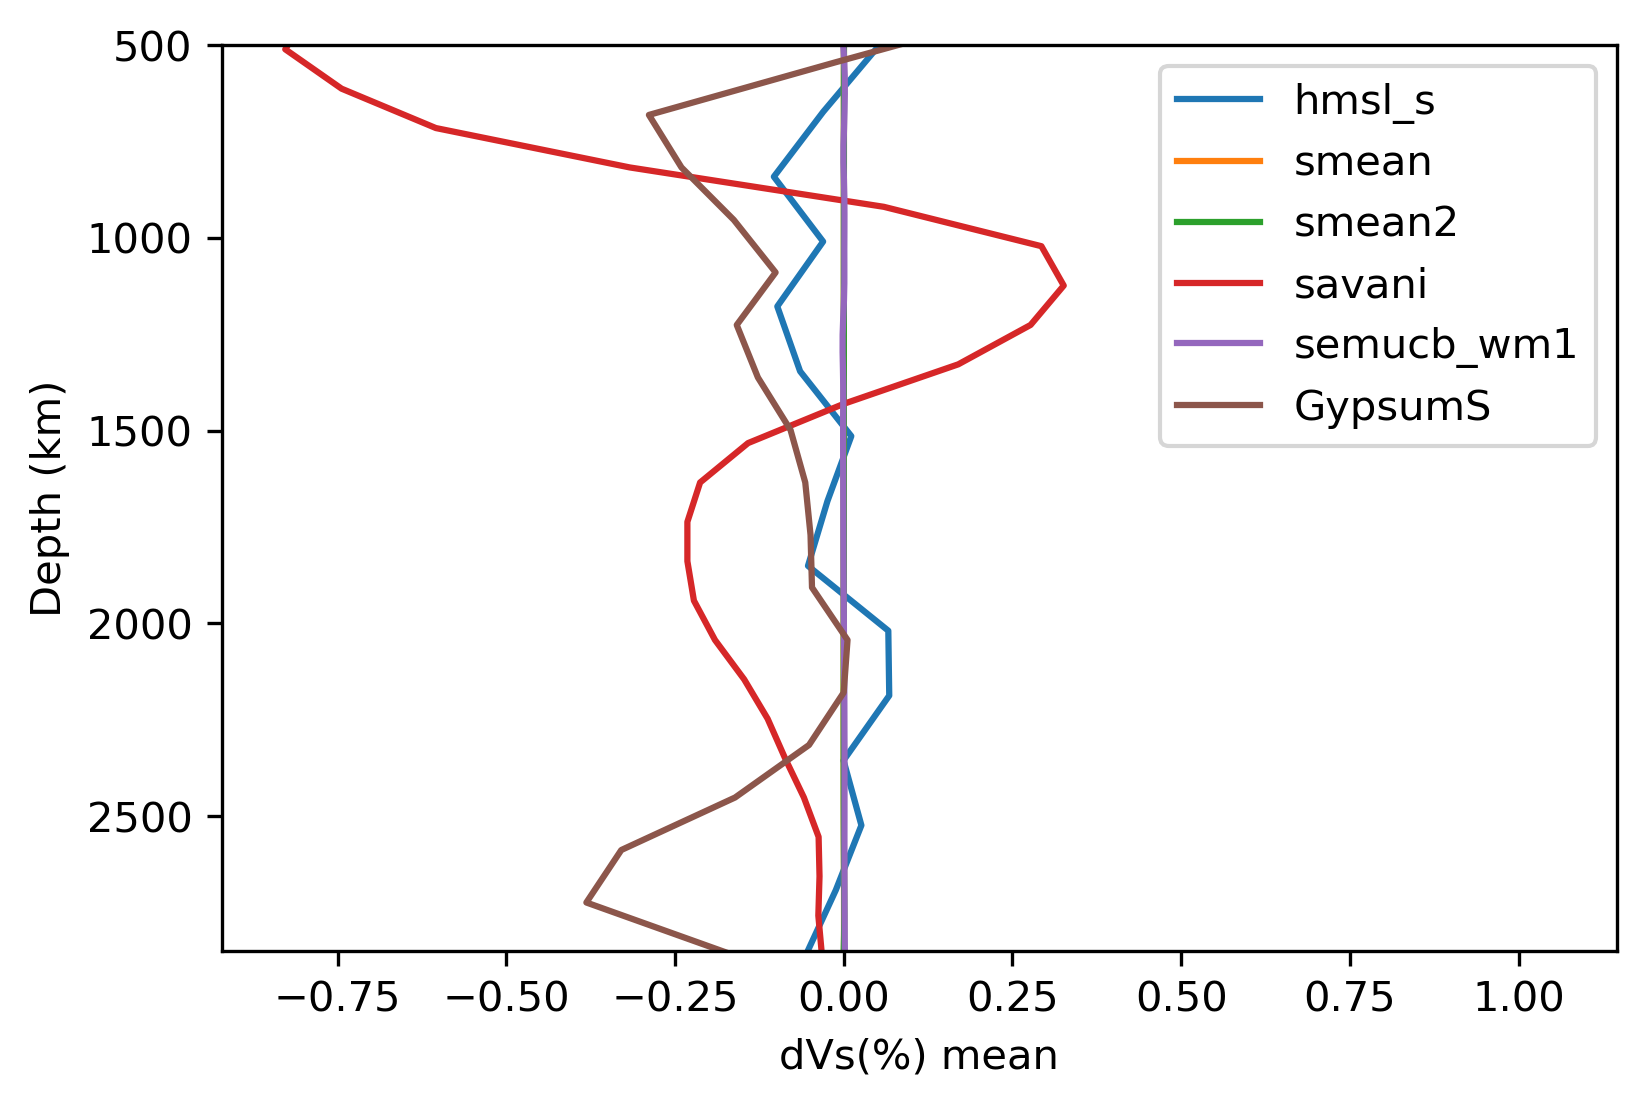

In [15]:
plt.close()


plt.plot(np.asarray(hmsl_s_Mean,dtype='float64'),np.linspace(0,2860,len(hmsl_s_Mean)),label='hmsl_s')

plt.plot(np.asarray(smean_Mean,dtype='float64'),np.linspace(0,2860,len(smean_Mean)),label='smean')

plt.plot(np.asarray(smean2_Mean,dtype='float64'),np.linspace(0,2860,len(smean2_Mean)),label='smean2')

plt.plot(np.asarray(SavaniMean,dtype='float64'),np.linspace(0,2860,len(SavaniMean)),label='savani')

plt.plot(np.asarray(semucb_wm1_Mean,dtype='float64'),np.linspace(0,2860,len(semucb_wm1_Mean)),label='semucb_wm1')

plt.plot(np.asarray(GypsumS_Mean,dtype='float64'),np.linspace(0,2860,len(GypsumS_Mean)),label='GypsumS')

plt.legend()
plt.gca().invert_yaxis()

plt.ylabel('Depth (km)')
plt.xlabel('dVs(%) mean')
plt.ylim(2850,500)
plt.gca().figure.dpi=300
plt.show()




# Tomography Models Comparison

In [4]:
Kimberlites_Below_hmsl_s=np.load("/Users/omer/Documents/Data_Tomography_Geology/\
Tomography_models/HMSL.S/Tomography/KimberliteField_below_HMSL_S_Reconstructed_200Ma_0Ma.npy")

Kimberlites_Below_semucb_wm1=np.load("/Users/omer/Documents/Data_Tomography_Geology/\
Tomography_models/SEMUCB-WM1/Tomography/KimberliteField_below_semucb_wm1_Reconstructed_200Ma_0Ma.npy")

Kimberlites_Below_smean=np.load("/Users/omer/Documents/Data_Tomography_Geology/\
Tomography_models/smean/KimberliteField_below_smean_Reconstructed_200Ma_0Ma.npy")

Kimberlites_Below_smean2=np.load("/Users/omer/Documents/Data_Tomography_Geology/\
Tomography_models/smean2/KimberliteField_below_smean2_Reconstructed_200Ma_0Ma.npy")

Kimberlites_Below_s40rts=np.load("/Users/omer/Documents/Data_Tomography_Geology/\
Tomography_models/s40rts/KimberliteField_below_s40rts_Reconstructed_200Ma_0Ma.npy")

Kimberlites_Below_GypsumS=np.load("/Users/omer/Documents/Data_Tomography_Geology/\
Tomography_models/GypsumS/KimberliteField_below_GypsumS_Reconstructed_200Ma_0Ma.npy")

Kimb_below_Savani=np.load("/Users/omer/Documents/Data_Tomography_Geology/\
Tomography_models/savani/KimberliteField_below_Savani_Reconstructed_200Ma_0Ma.npy")



In [6]:
Kimberlites_Below_smean2.shape,Kimberlites_Below_hmsl_s.shape

((679, 58, 1), (679, 18, 1))

In [7]:
df=pd.DataFrame(Kimberlites_Below_hmsl_s.reshape(762,11))
df.mean()

ValueError: cannot reshape array of size 12222 into shape (762,11)

# PLOT ALL

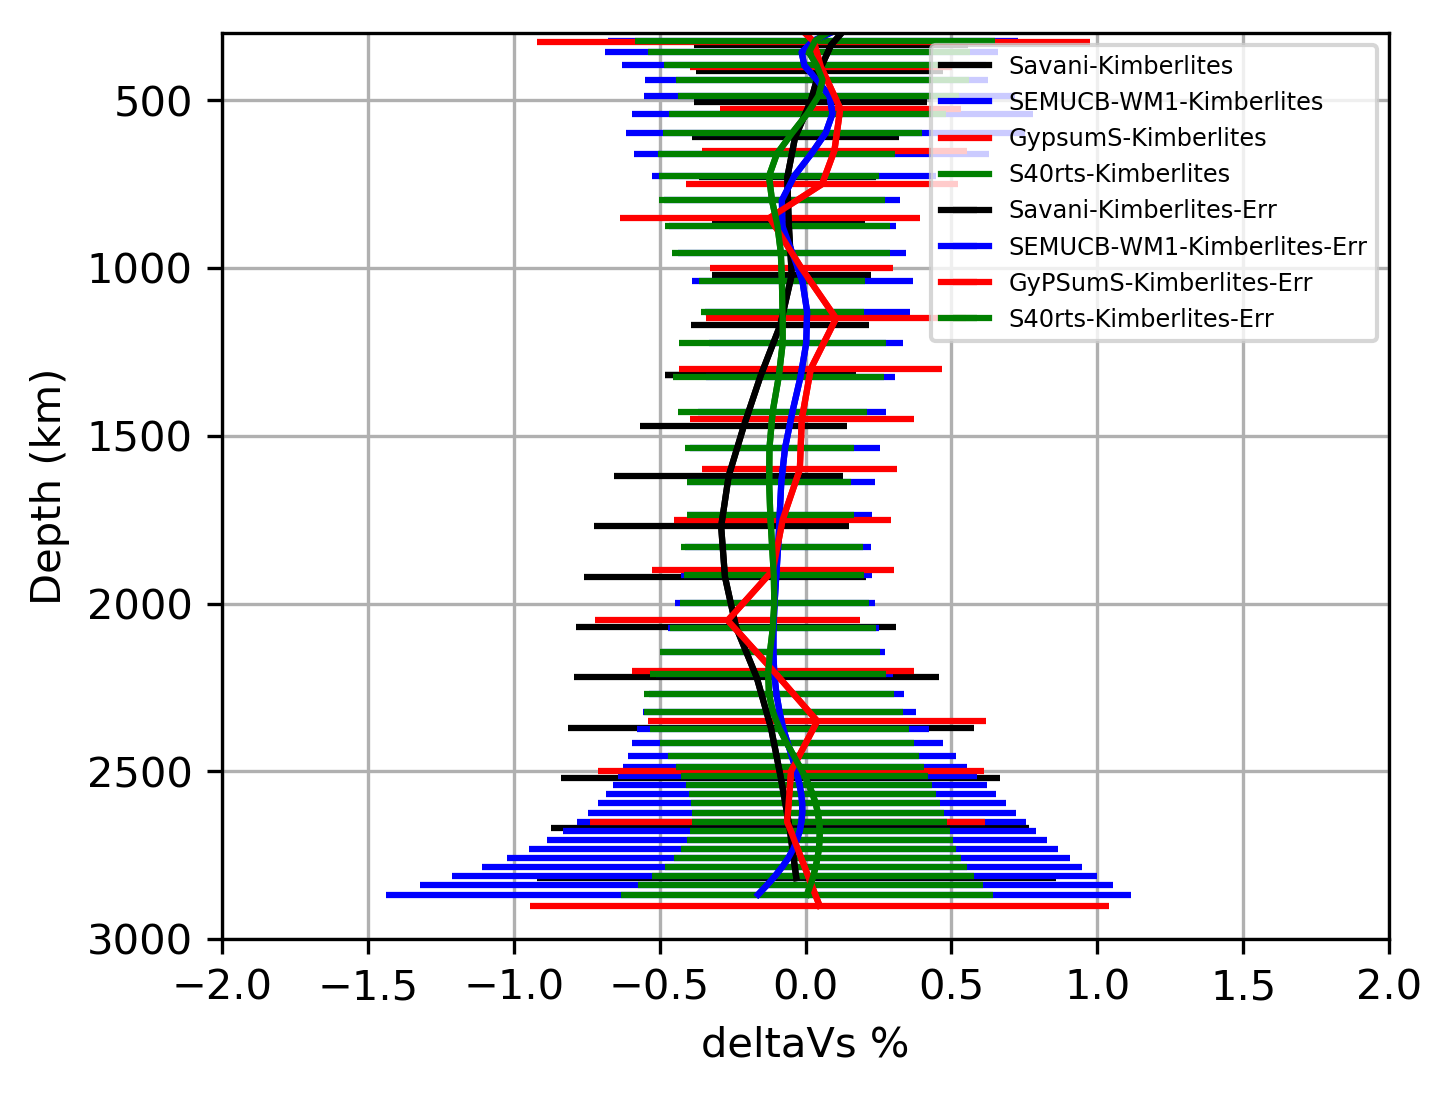

In [35]:
# f=open('/Users/omer/Documents/Data_Tomography_Geology/HMSL_S_depths.txt','r')
# DEPTHLIST=[]
# for line in f:
#     DEPTHLIST.append(line.strip())

# df=pd.DataFrame(Kimberlites_Below_hmsl_s.reshape(679,18))
# plt.plot(df.mean()-np.asarray(hmsl_s_Mean,dtype='float64'),np.asarray(DEPTHLIST,dtype="float64"),c='orange',label="HMSL_S-Kimberlites",linestyle=':')
# # plt.plot(hmsl_s_Mean,np.asarray(DEPTHLIST,dtype="float64"),c='k',linestyle='dashed',label="HMSL_S-global-mean")

f=open('/Users/omer/Documents/Data_Tomography_Geology/savani_depths.txt','r')
DEPTHLIST=[]
for line in f:
    DEPTHLIST.append(line.strip())

df=pd.DataFrame(Kimb_below_Savani.reshape(679,29))
# plt.plot(df.mean(),np.asarray(DEPTHLIST,dtype="float64"),c='black',label="Savani-Kimberlites",linestyle='-')
# plt.plot(SavaniMean,np.asarray(DEPTHLIST,dtype="float64"),c='b',linestyle='dashed',label="Savani-global-mean")

plt.plot(df.mean()-np.asarray(SavaniMean,dtype='float64'),np.asarray(DEPTHLIST,dtype="float64"),
         c='black',label="Savani-Kimberlites",linestyle='-')

f=open('/Users/omer/Documents/Programming/GMT_Scripts/Savani_std.txt','r')
STD=[]
for line in f:
    STD.append(line.strip())

STD=np.asarray(STD,dtype="float64")

plt.errorbar(df.mean()-np.asarray(SavaniMean,dtype='float64'),
             np.asarray(DEPTHLIST,dtype="float64"),xerr=STD,
             c='black',label="Savani-Kimberlites-Err",linestyle='-')




# f=open('/Users/omer/Documents/Data_Tomography_Geology/Tomography_models/smean/smean_depths.txt','r')
# DEPTHLIST=[]
# for line in f:
#     DEPTHLIST.append(line.strip())

# df=pd.DataFrame(Kimberlites_Below_smean.reshape(679,29))
# plt.plot(df.mean()-np.asarray(smean_Mean,dtype='float64'),np.asarray(DEPTHLIST,dtype="float64"),c='black',label="Smean-Kimberlites",linestyle=':')
# # plt.plot(smean_Mean,np.asarray(DEPTHLIST,dtype="float64"),c='orange',linestyle='dashed',label="Smean-global-mean")


# f=open('/Users/omer/Documents/Data_Tomography_Geology/Tomography_models/smean2/smean2_depths.txt','r')
# DEPTHLIST=[]
# for line in f:
#     DEPTHLIST.append(line.strip())

# df=pd.DataFrame(Kimberlites_Below_smean2.reshape(679,58))
# plt.plot(df.mean()-np.asarray(smean2_Mean,dtype='float64'),np.asarray(DEPTHLIST,dtype="float64"),c='black',label="Smean2-Kimberlites",linestyle='--')
# # plt.plot(smean2_Mean,np.asarray(DEPTHLIST,dtype="float64"),c='purple',linestyle='dashed',label="Smean2-global-mean")



f=open('/Users/omer/Documents/Data_Tomography_Geology/semucb-wm1_depths.txt','r')
DEPTHLIST=[]
for line in f:
    DEPTHLIST.append(line.strip())

df=pd.DataFrame(Kimberlites_Below_semucb_wm1.reshape(679,65))
plt.plot(df.mean()-np.asarray(semucb_wm1_Mean,dtype='float64'),np.asarray(DEPTHLIST,dtype="float64"),
         c='blue',label="SEMUCB-WM1-Kimberlites", linestyle='-')
# plt.plot(semucb_wm1_Mean,np.asarray(DEPTHLIST,dtype="float64"),c='green',linestyle='dashed',label="SEMUCB-WM1-global-mean")

f=open('/Users/omer/Documents/Programming/GMT_Scripts/semucb_std.txt','r')
STD=[]
for line in f:
    STD.append(line.strip())
    
STD=np.asarray(STD,dtype="float64")

plt.errorbar(df.mean()-np.asarray(semucb_wm1_Mean,dtype='float64'),
             np.asarray(DEPTHLIST,dtype="float64"),xerr=STD,
             c='blue',label="SEMUCB-WM1-Kimberlites-Err",linestyle='-')




f=open('/Users/omer/Documents/Data_Tomography_Geology/GypsumS_depths.txt','r')
DEPTHLIST=[]
for line in f:
    DEPTHLIST.append(line.strip())

df=pd.DataFrame(Kimberlites_Below_GypsumS.reshape(679,22))
plt.plot(df.mean()-np.asarray(GypsumS_Mean,dtype='float64'),np.asarray(DEPTHLIST,dtype="float64"),
         c='red',label="GypsumS-Kimberlites", linestyle='-')
# plt.plot(GypsumS_Mean,np.asarray(DEPTHLIST,dtype="float64"),c='cyan',linestyle='dashed',label="GypsumS-global-mean")

f=open('/Users/omer/Documents/Programming/GMT_Scripts/Gypsums_std.txt','r')
STD=[]
for line in f:
    STD.append(line.strip())
STD=np.asarray(STD,dtype="float64")

plt.errorbar(df.mean()-np.asarray(GypsumS_Mean,dtype='float64'),
             np.asarray(DEPTHLIST,dtype="float64"),xerr=STD,
             c='red',label="GyPSumS-Kimberlites-Err",linestyle='-')



f=open('/Users/omer/Documents/Data_Tomography_Geology/s40rts_depths.txt','r')
DEPTHLIST=[]
for line in f:
    DEPTHLIST.append(line.strip())

df=pd.DataFrame(Kimberlites_Below_s40rts.reshape(679,65))
plt.plot(df.mean()-np.asarray(s40rts_Mean,dtype='float64'),np.asarray(DEPTHLIST,dtype="float64"),
         c='green',label="S40rts-Kimberlites",linestyle='-')
# plt.plot(s40rts_Mean,np.asarray(DEPTHLIST,dtype="float64"),c='red',linestyle='dashed',label="S40rts-global-mean")

f=open('/Users/omer/Documents/Programming/GMT_Scripts/s40rts_std.txt','r')
STD=[]
for line in f:
    STD.append(line.strip())

STD=np.asarray(STD,dtype="float64")

plt.errorbar(df.mean()-np.asarray(s40rts_Mean,dtype='float64'),
             np.asarray(DEPTHLIST,dtype="float64"),xerr=STD,
             c='green',label="S40rts-Kimberlites-Err",linestyle='-')

# plt.fill(df.mean()-np.asarray(s40rts_Mean,dtype='float64')-STD,
#                  df.mean()-np.asarray(s40rts_Mean,dtype='float64')+STD,
#                  np.asarray(DEPTHLIST,dtype="float64"),alpha=0.5)

plt.plot()


# plt.title('Kimberlites x hmsl.s')    
plt.gca().invert_yaxis()
plt.xlabel("deltaVs %")
plt.ylabel("Depth (km)")
plt.gca().figure.dpi=300   
plt.xlim(-2,2)
# plt.xticks([-1.2,-1.0,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4])
plt.ylim(3000,300)
plt.legend(fontsize='xx-small')
plt.grid()
plt.gca().set_aspect(1.15e-3)
# plt.show()
plt.savefig('Fig1-NG-Reviews-With_errorBars-M21-NNRV2.pdf',dpi=300)
# plt.savefig('Tomography_vsDepth_Shifted_by_mean-18July2022.png',dpi=300)


    
        

In [79]:
Kimberlites_Below_smean2.shape

(762, 58, 1)

In [14]:
Kimberlites_Below_hmsl_s

array([[[ 2.08356357],
        [ 2.87393618],
        [-0.2611064 ],
        ...,
        [-0.26864138],
        [-0.35723117],
        [-0.95696163]],

       [[-1.5410111 ],
        [ 2.49174023],
        [-1.16344821],
        ...,
        [-0.32263499],
        [-0.68924612],
        [-0.91383934]],

       [[ 2.0909667 ],
        [ 2.97446465],
        [ 0.01253613],
        ...,
        [-0.21185473],
        [ 0.10221533],
        [ 0.10357671]],

       ...,

       [[-0.59847802],
        [ 4.58617592],
        [ 0.28551286],
        ...,
        [ 0.13210244],
        [ 0.46784762],
        [-0.3087801 ]],

       [[ 1.0529635 ],
        [ 5.3930645 ],
        [ 3.2985487 ],
        ...,
        [-0.99971223],
        [-0.74069703],
        [-1.12638915]],

       [[ 0.77476168],
        [ 1.24339962],
        [-1.19275999],
        ...,
        [-0.57278204],
        [-0.16625984],
        [ 0.16602488]]])